# Cloudy With a Chance of Football - Offense Machine Learning Model

Author: Griffin Taub
Date: 26 June 2021

# Import packages, connect to db, read in data

In [1]:
# Packages to import and manipulate data
import pandas as pd
import numpy as np
import sqlite3

# Packages to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Packages to create and visualize machine learning models from yellowbrick
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import confusion_matrix

# Packages to create machine learning models from scikit-learn
from sklearn.model_selection import train_test_split as tts
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

In [2]:
# Set pandas viewing options
pd.set_option('display.max_columns', None)

# Bring in jupyter magic
%matplotlib inline

# Set matplotlib visualization styling options
plt.rcParams['figure.figsize'] = (18,6)
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('../../fixtures/cleaned_data/merged_df.csv')

In [4]:
# Read in all data from database and merge the data on player_id
conn = sqlite3.connect('../../fixtures/database/cloudy_with_a_chance_of_football.db')
cursorObj = conn.cursor()

target = pd.read_sql_query('SELECT * from performance_target',conn)

# Dataframe prep

In [5]:
df = pd.merge(
    df,
    target,
    how = 'left',
    left_on = ['PlayerID','week_id','performance'],
    right_on = ['PlayerID','week_id','performance']
)

df

GameKey  PlayerID  Season  Week Team Opponent HomeOrAway Position  \
0      201910101         1    2019     1  ARZ      DET       HOME      DEF   
1      201910203         1    2019     2  ARZ      BLT       AWAY      DEF   
2      201910301         1    2019     3  ARZ      CAR       HOME      DEF   
3      201910401         1    2019     4  ARZ      SEA       HOME      DEF   
4      201910507         1    2019     5  ARZ      CIN       AWAY      DEF   
...          ...       ...     ...   ...  ...      ...        ...      ...   
19210  202010924     22482    2020     9  NYJ       NE       HOME        K   
19211  202011129     22482    2020    11  NYJ      LAC       AWAY        K   
19212  202011224     22482    2020    12  NYJ      MIA       HOME        K   
19213  202011324     22482    2020    13  NYJ       LV       HOME        K   
19214  202011430     22482    2020    14  NYJ      SEA       AWAY        K   

      PositionCategory  InjuryStatus  TeamID  OpponentID  ScoreID  week_id  \
0                  DEF             0       1          11    16994   2019_1   
1                  DEF             0       1           3    17008   2019_2   
2                  DEF             0       1           5    17024   2019_3   
3                  DEF             0       1          30    17041   2019_4   
4                  DEF             0       1           7    17047   2019_5   
...                ...           ...     ...         ...      ...      ...   
19210               ST             0      24          21    17396   2020_9   
19211               ST             0      24          29    17645  2020_11   
19212               ST             0      24          19    17433  2020_12   
19213               ST             0      24          25    17446  2020_13   
19214               ST             0      24          30    17465  2020_14   

      OpponentRZ  days_since_last_game  absolute_hours_displaced  \
0              0                   365                         0   
1              0                     7                         2   
2              0                     7                         0   
3              0                     7                         0   
4              0                     7                         2   
...          ...                   ...                       ...   
19210          0                     8                         0   
19211          0                    13                         3   
19212          0                     7                         0   
19213          0                     7                         0   
19214          0                     7                         3   

       weather_temperature  weather_wind_mph_number weather_wind_direction  \
0                       72                        0                No wind   
1                       81                        3      North - NorthWest   
2                       72                        0                No wind   
3                       72                        0                No wind   
4                       76                        6       West - SouthWest   
...                    ...                      ...                    ...   
19210                   60                        3      South - SouthWest   
19211                   69                        4              SouthWest   
19212                   51                        3              SouthWest   
19213                   39                       13              NorthWest   
19214                   41                        6      South - SouthEast   

       weather_cloud_cover  weather_precipitation  weather_humidity  \
0                     0.39                    0.0              0.32   
1                     0.00                    0.0              0.45   
2                     0.40                    0.0              0.90   
3                     0.38                    0.0              0.36   
4                     0.87

In [6]:
df = df.drop('Season', axis = 'columns').sort_values(by = ['Week']).reset_index(drop = True)
df

GameKey  PlayerID  Week Team Opponent HomeOrAway Position  \
0      201910101         1     1  ARZ      DET       HOME      DEF   
1      202010105     20924     1   LV      CAR       AWAY       WR   
2      201910125     20924     1   LV      DEN       HOME       WR   
3      201910125     16311     1   LV      DEN       HOME       QB   
4      202010111     20925     1  CHI      DET       AWAY       WR   
...          ...       ...   ...  ...      ...        ...      ...   
19210  201911707     19798    17  CLV      CIN       AWAY       RB   
19211  202011733     18880    17   TB      ATL       HOME       WR   
19212  202011710     15126    17   LV      DEN       AWAY       RB   
19213  201911730     17217    17   SF      SEA       AWAY       RB   
19214  201911733     18880    17   TB      ATL       HOME       WR   

      PositionCategory  InjuryStatus  TeamID  OpponentID  ScoreID  week_id  \
0                  DEF             0       1          11    16994   2019_1   
1                  OFF             0      25           5    17270   2020_1   
2                  OFF             0      25          10    16998   2019_1   
3                  OFF             0      25          10    16998   2019_1   
4                  OFF             0       6          11    17266   2020_1   
...                ...           ...     ...         ...      ...      ...   
19210              OFF             0       8           7    17224  2019_17   
19211              OFF             0      33           2    17513  2020_17   
19212              OFF             0      25          10    17516  2020_17   
19213              OFF             0      31          30    17238  2019_17   
19214              OFF             0      33           2    17231  2019_17   

      OpponentRZ  days_since_last_game  absolute_hours_displaced  \
0              0                   365                         0   
1            CAR                   259                         3   
2            DEN                   365                         0   
3            DEN                   365                         0   
4              0                   259                         1   
...          ...                   ...                       ...   
19210        CIN                     7                         0   
19211        ATL                     8                         0   
19212        DEN                     8                         1   
19213        SEA                     8                         0   
19214          0                     8                         0   

       weather_temperature  weather_wind_mph_number weather_wind_direction  \
0                       72                        0                No wind   
1                       79                        3              NorthEast   
2                       64                       10       West - SouthWest   
3                       64                       10       West - SouthWest   
4                       72                        0                No wind   
...                    ...                      ...                    ...   
19210                   60                        8      South - SouthWest   
19211                   64                        5      North - NorthWest   
19212                   54                        7              SouthWest   
19213                   47                        1                  South   
19214                   78                       10                  South   

       weather_cloud_cover  weather_precipitation  weather_humidity  \
0                     0.39                    0.0              0.32   
1                     0.17                    0.0              0.66   
2                     0.20                    0.0              0.69   
3                     0.20                    0.0              0.69   
4                     0.12                    0.0              0.65   
...                    ...                    ...  

Drop defense and kickers , don't apply to offense model

In [7]:
df = df[df.Position != 'DEF']

In [8]:
df = df[df.Position != 'K']

Drop columns that don't apply to offense model

In [9]:
df.drop(['PuntReturns',
'PuntReturnYards',
'PuntReturnTouchdowns',
'KickReturns',
'KickReturnYards',
'KickReturnTouchdowns',
'SoloTackles',
'AssistedTackles',
'TacklesForLoss',
'Sacks',
'SackYards',
'QuarterbackHits',
'PassesDefended',
'FumblesForced',
'FumblesRecovered',
'FumbleReturnTouchdowns',
'Interceptions',
'InterceptionReturnTouchdowns',
'FieldGoalsAttempted',
'FieldGoalsMade',
'ExtraPointsMade',
'ExtraPointsAttempted',
'FieldGoalsMade0to19',
'FieldGoalsMade20to29',
'FieldGoalsMade30to39',
'FieldGoalsMade40to49',
'FieldGoalsMade50Plus',
'PointsAllowedByDefenseSpecialTeams',
'BlockedKickReturnTouchdowns',
'SpecialTeamsTouchdowns',
'DefensiveTouchdowns',
'BlockedKicks',
'TwoPointConversionReturns',
'FieldGoalReturnTouchdowns',
'Safeties',
'SacksRZ',
'InterceptionsRZ',
'FumblesForcedRZ',
'FumlbesRecoveredRZ'  
], axis=1, inplace=True)

# Data Exploration

In [10]:
df.head()

GameKey  PlayerID  Week Team Opponent HomeOrAway Position  \
1  202010105     20924     1   LV      CAR       AWAY       WR   
2  201910125     20924     1   LV      DEN       HOME       WR   
3  201910125     16311     1   LV      DEN       HOME       QB   
4  202010111     20925     1  CHI      DET       AWAY       WR   
5  202010116     16568     1  HST       KC       AWAY       WR   

  PositionCategory  InjuryStatus  TeamID  OpponentID  ScoreID week_id  \
1              OFF             0      25           5    17270  2020_1   
2              OFF             0      25          10    16998  2019_1   
3              OFF             0      25          10    16998  2019_1   
4              OFF             0       6          11    17266  2020_1   
5              OFF             1      13          16    17263  2020_1   

  OpponentRZ  days_since_last_game  absolute_hours_displaced  \
1        CAR                   259                         3   
2        DEN                   365                         0   
3        DEN                   365                         0   
4          0                   259                         1   
5          0                   256                         0   

   weather_temperature  weather_wind_mph_number weather_wind_direction  \
1                   79                        3              NorthEast   
2                   64                       10       West - SouthWest   
3                   64                       10       West - SouthWest   
4                   72                        0                No wind   
5                   58                        6      North - NorthEast   

   weather_cloud_cover  weather_precipitation  weather_humidity  \
1                 0.17                    0.0              0.66   
2                 0.20                    0.0              0.69   
3                 0.20                    0.0              0.69   
4                 0.12                    0.0              0.65   
5                 0.10                    0.0              0.82   

  weather_detail  elevation_displacement        age  Played  Started  \
1          Clear                 2208777  24.732997       0        0   
2  Partly Cloudy                       0  23.721036       0        0   
3  Partly Cloudy                       0  28.454877       0        0   
4           DOME                   64922  24.149823       0        0   
5       Overcast                 2416099  26.962490       0        0   

   PassingAttempts  PassingCompletions  PassingYards  \
1              0.0                 0.0           0.0   
2              0.0                 0.0           0.0   
3              0.0                 0.0           0.0   
4              0.0                 0.0           0.0   
5              0.0                 0.0           0.0   

   PassingCompletionPercentage  PassingYardsPerAttempt  \
1                          0.0                     0.0   
2                          0.0                     0.0   
3                          0.0                     0.0   
4                          0.0                     0.0   
5                          0.0                     0.0   

   PassingYardsPerCompletion  PassingTouchdowns  PassingInterceptions  \
1                        0.0                0.0                   0.0   
2                        0.0                0.0                   0.0   
3                        0.0                0.0                   0.0   
4                        0.0                0.0                   0.0   
5                        0.0                0.0                   0.0   

   PassingRating  PassingLong  PassingSacks  PassingSackYards  \
1            0.0          0.0           0.0               0.0   
2            0.0          0.0           0.0               0.0   
3            0.0          0.0           0.0               0.0   
4            0.0          0.0           0.0               0.0   
5            0.0          0.0           0.0          

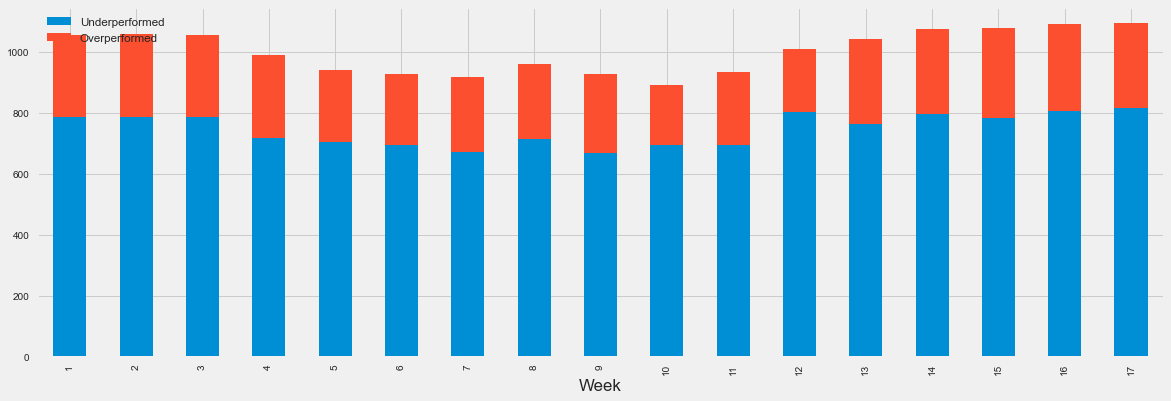

In [11]:
# Check out performance and value counts by week
agg_df = df.groupby(['Week','performance'])['Week'].count().unstack().fillna(0)

agg_df.plot(kind = 'bar', stacked = True)

plt.legend(
    ['Underperformed', 'Overperformed'],
    loc = 'upper left',
    fontsize = 'small'
)

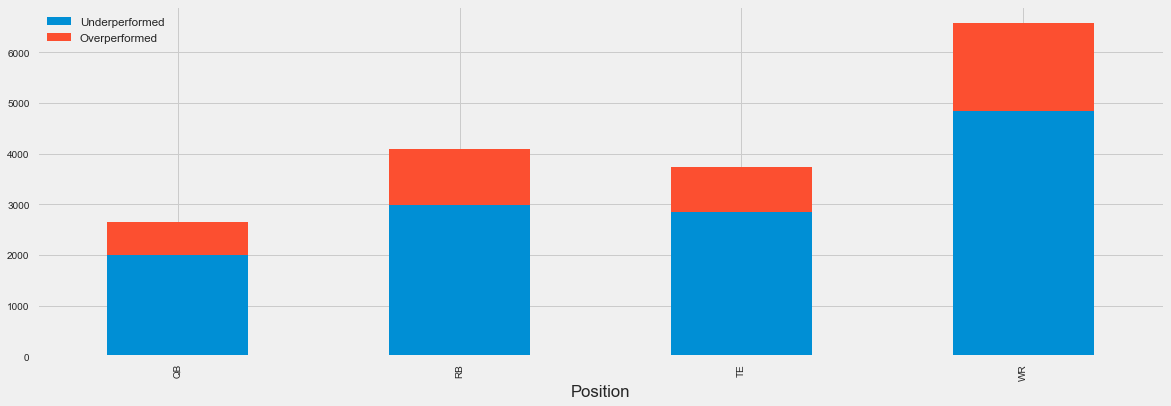

In [12]:
# Check out offense positions by performance
agg_df = df.groupby(['Position','performance'])['Week'].count().unstack().fillna(0)

agg_df.plot(kind = 'bar',
            stacked = True
)

plt.legend(
    ['Underperformed', 'Overperformed'],
    loc = 'upper left',
    fontsize = 'small'
)

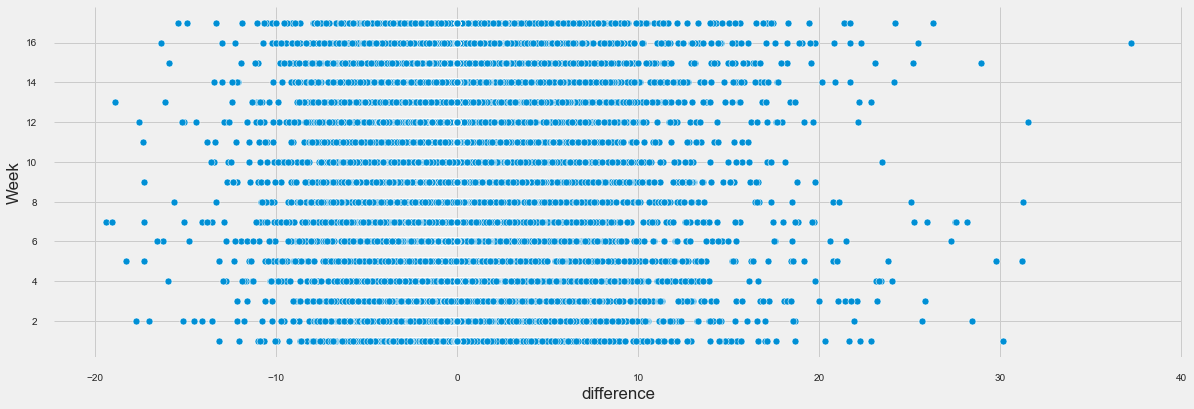

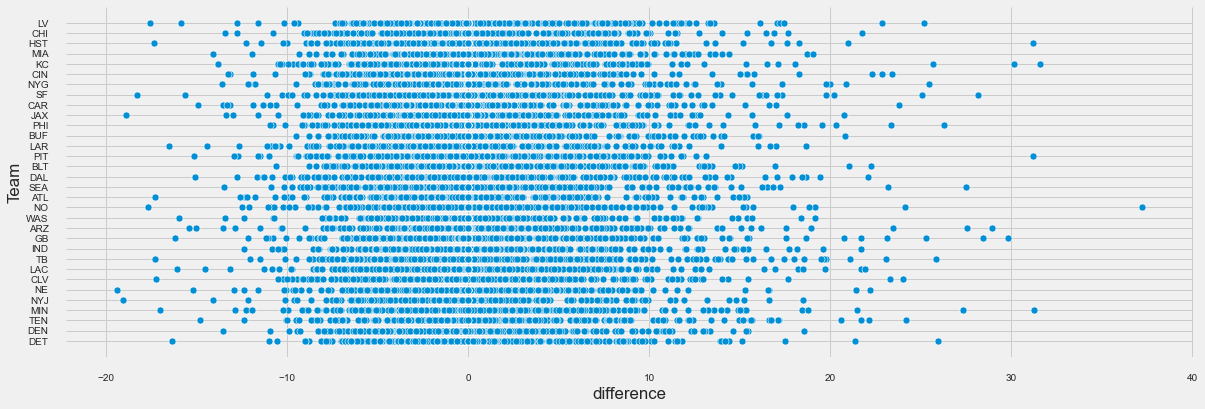

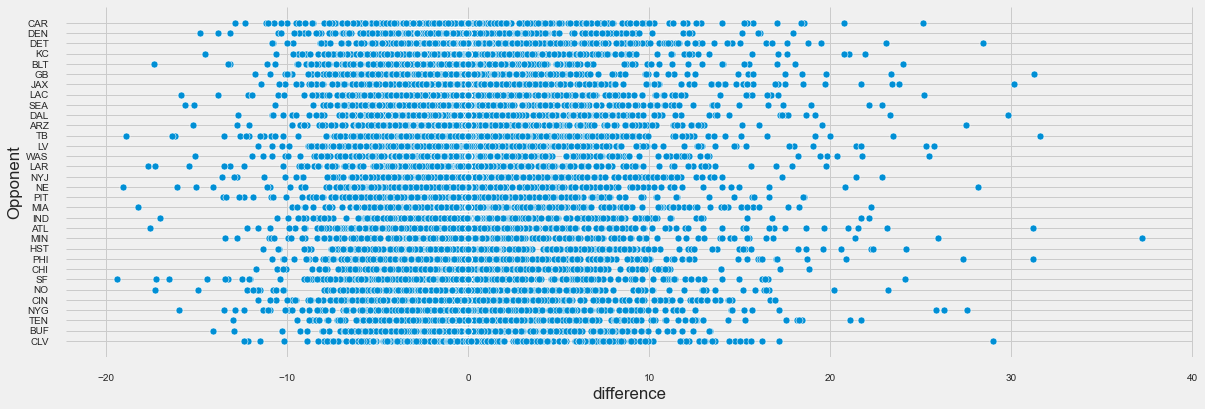

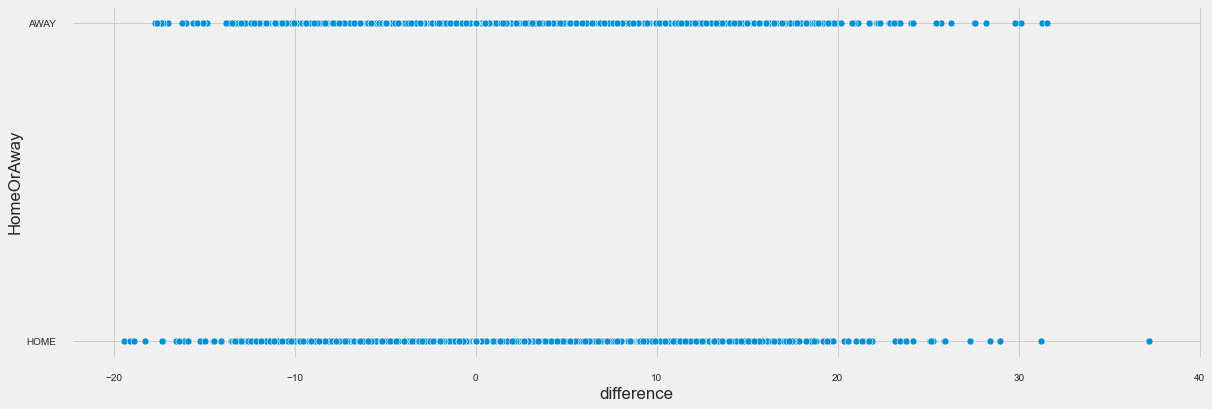

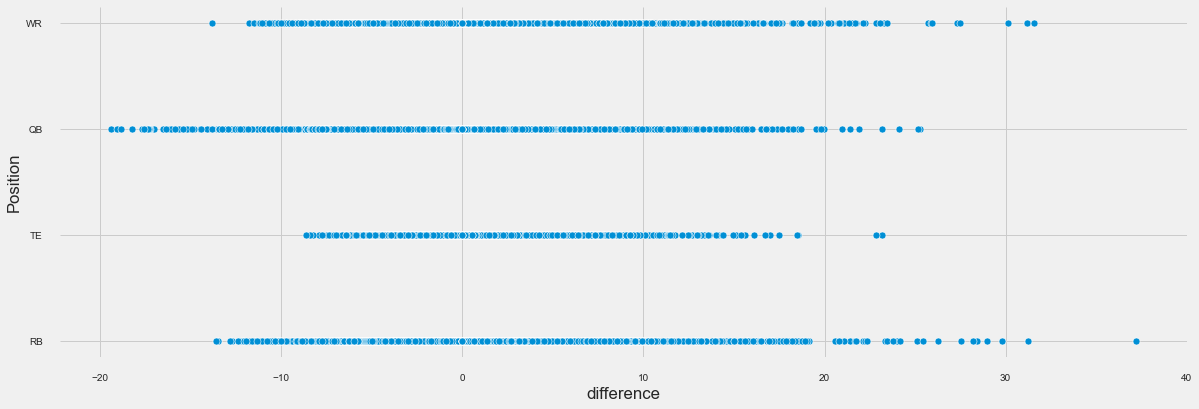

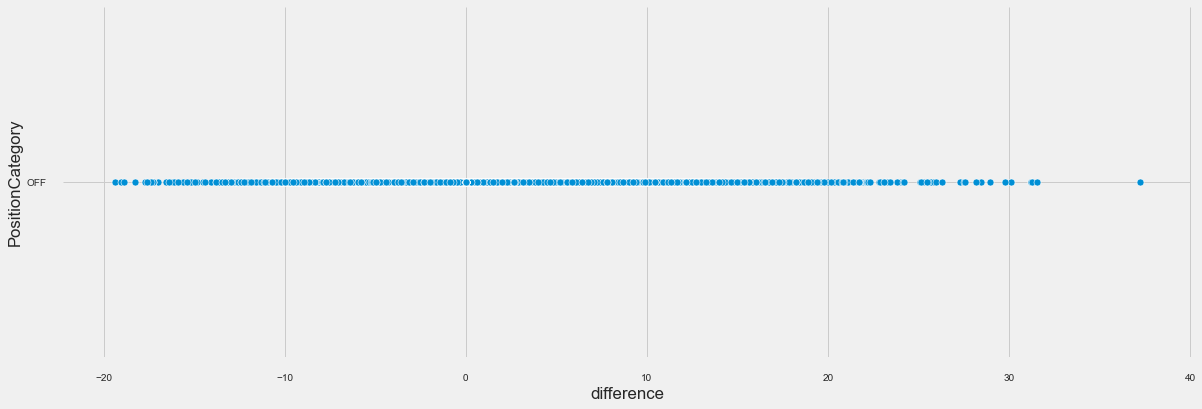

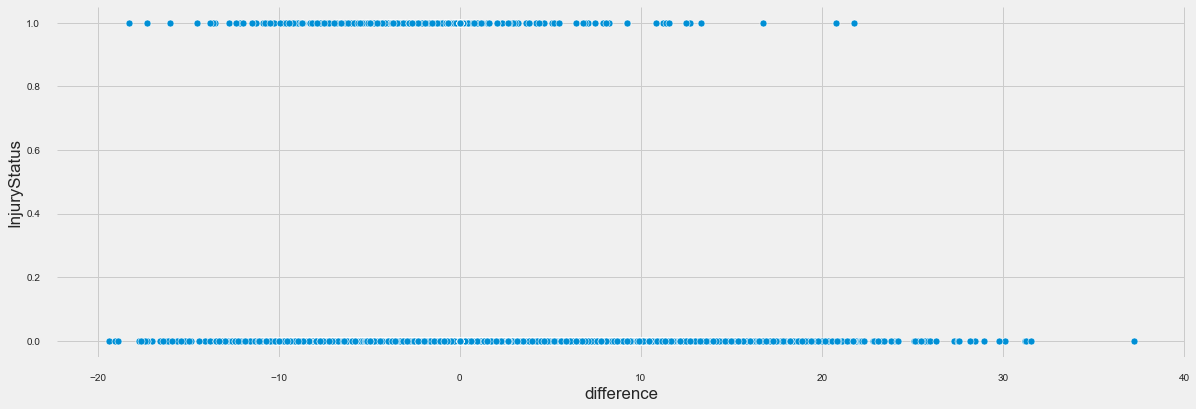

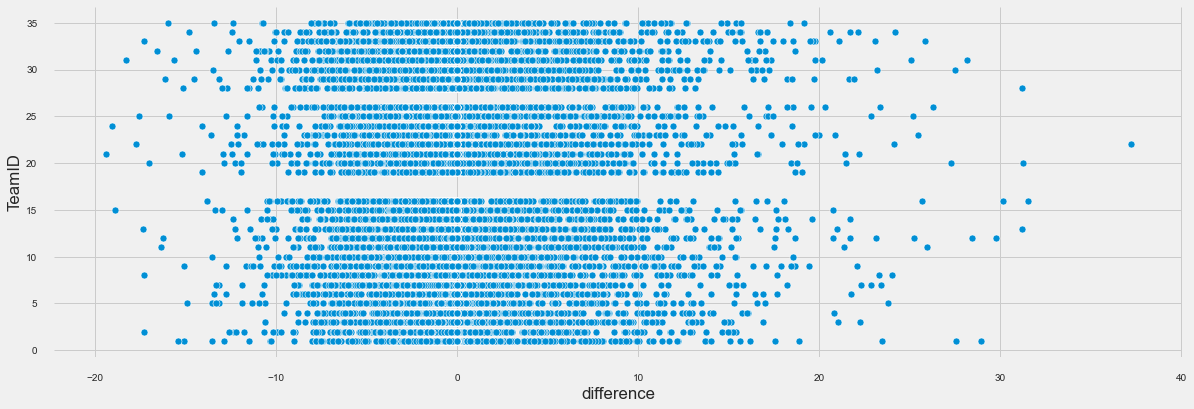

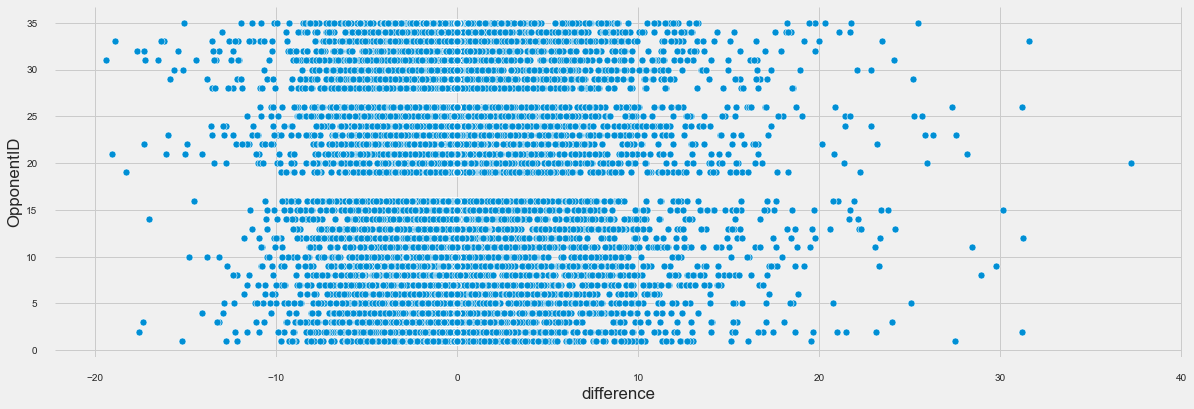

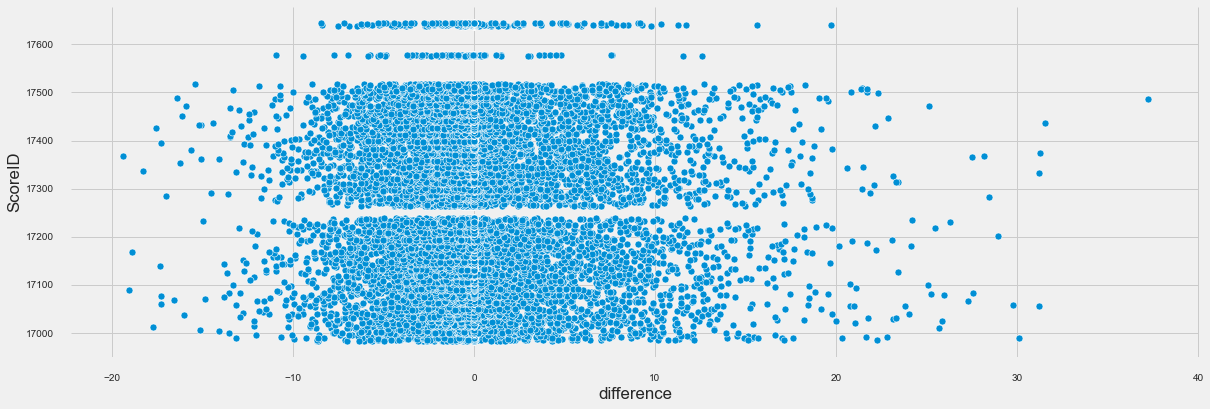

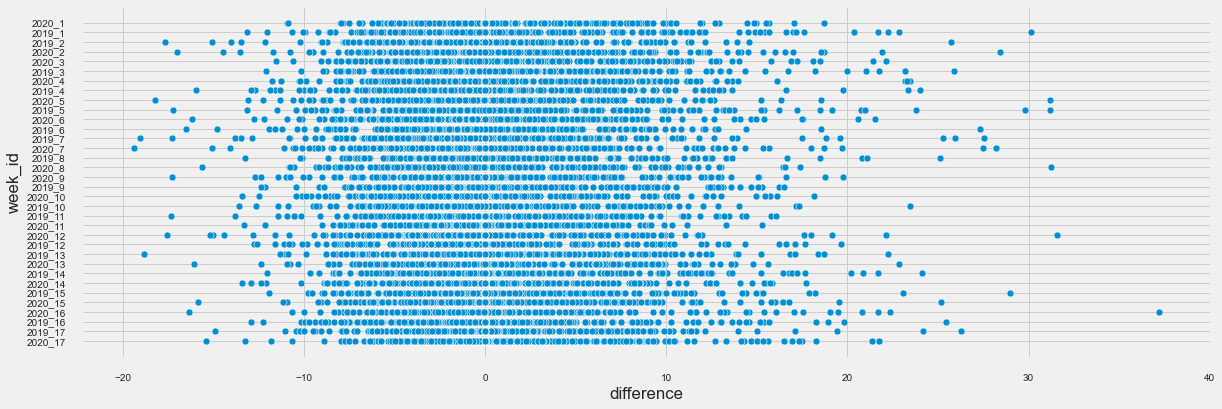

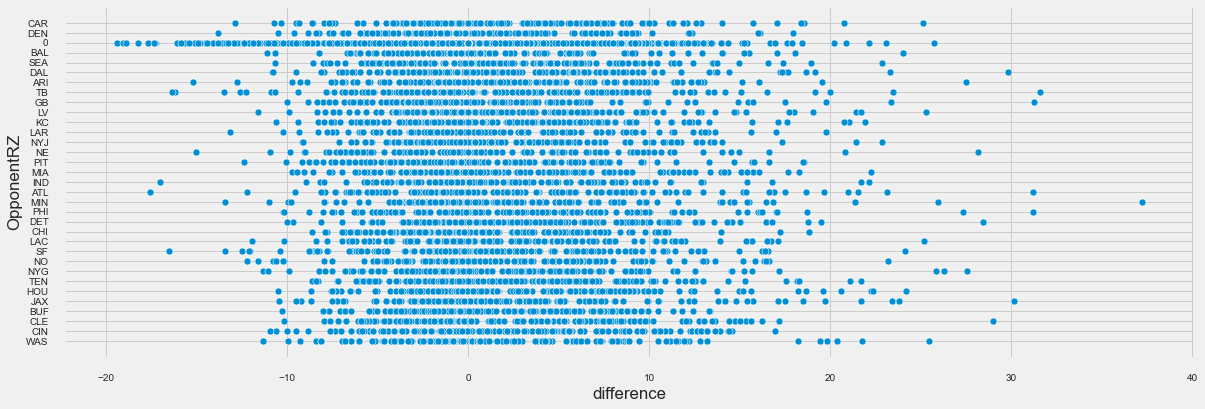

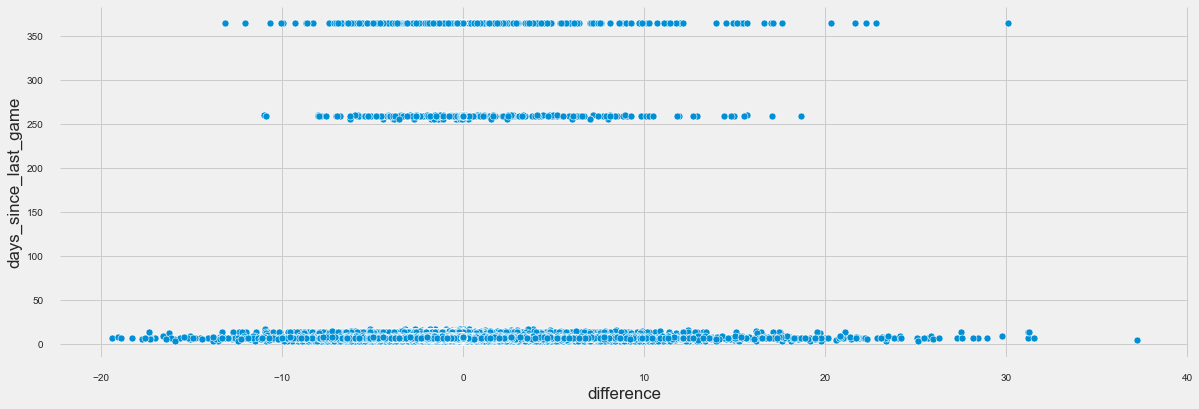

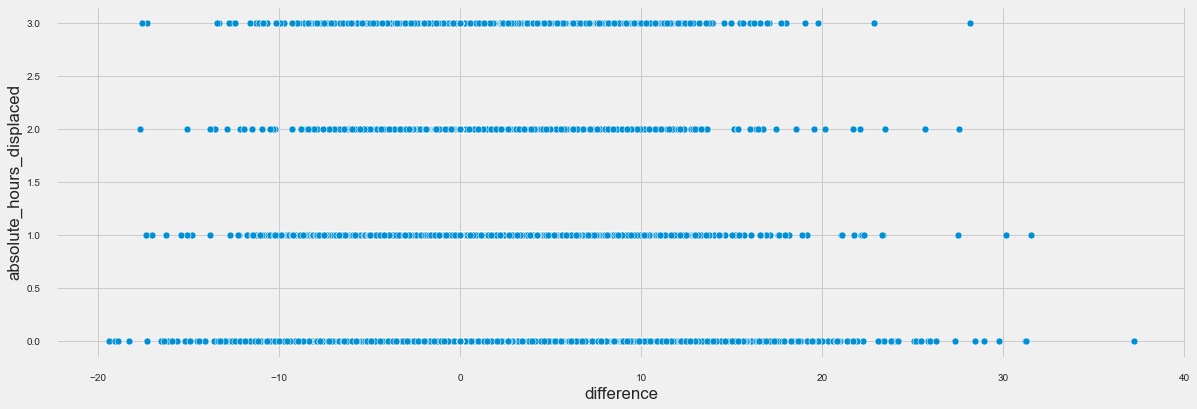

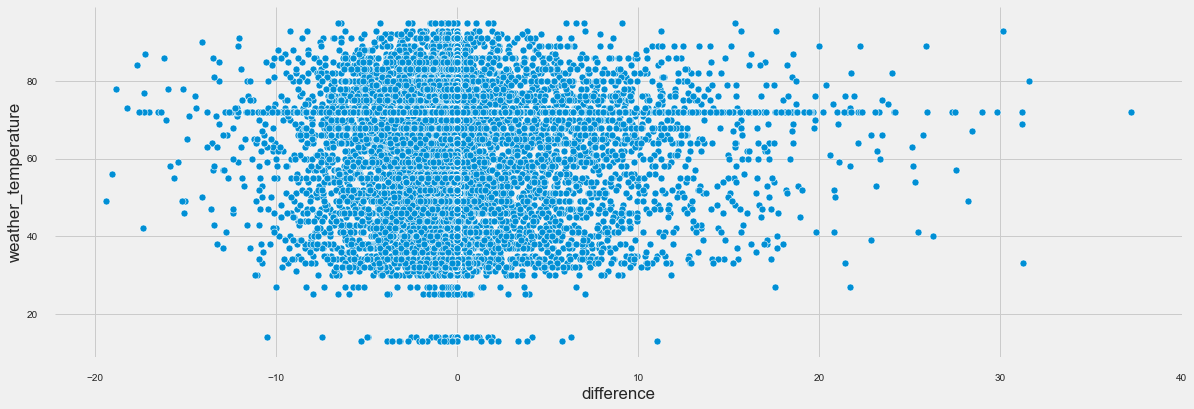

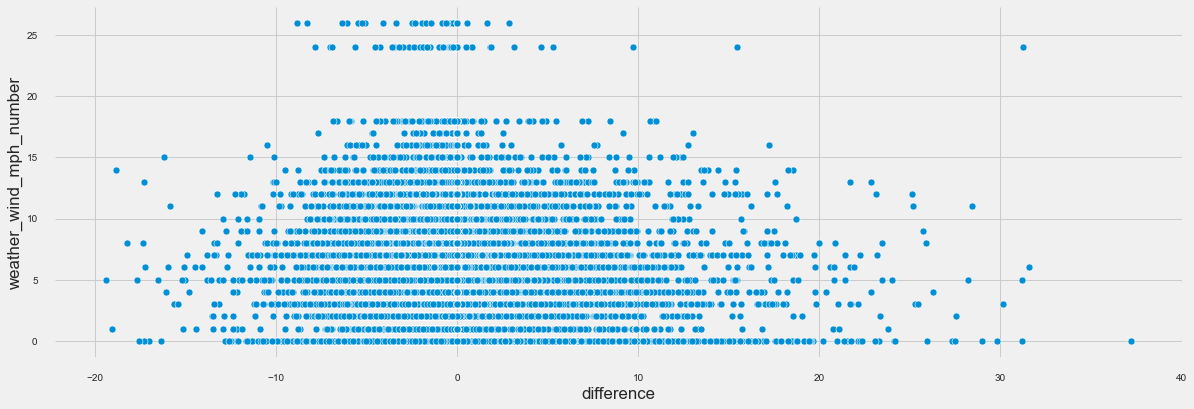

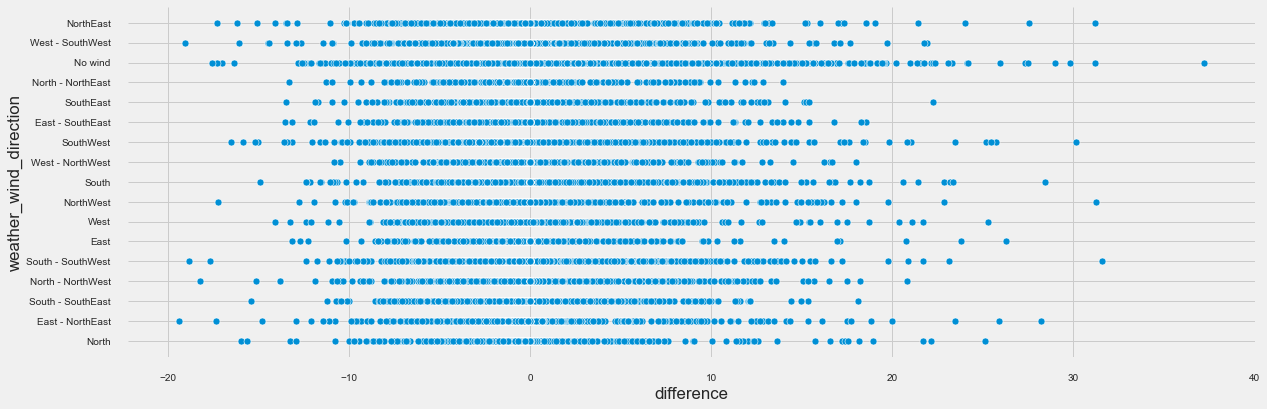

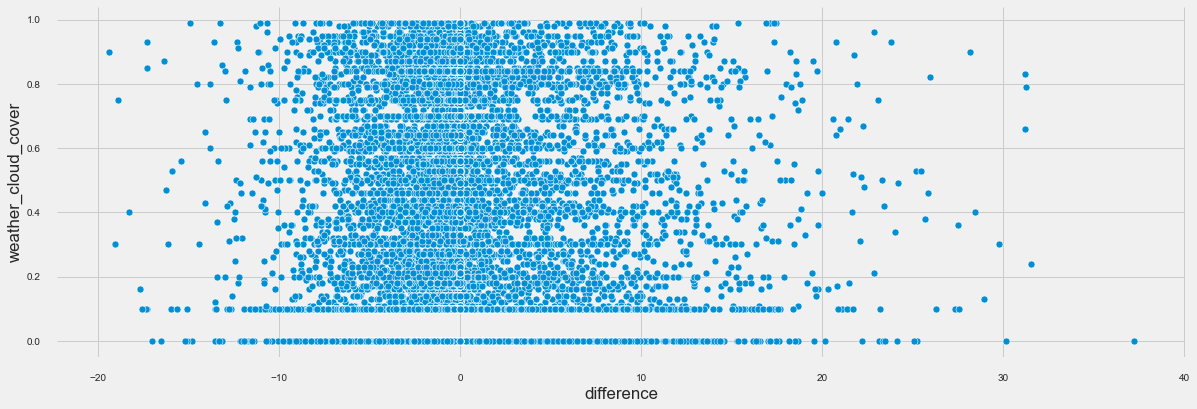

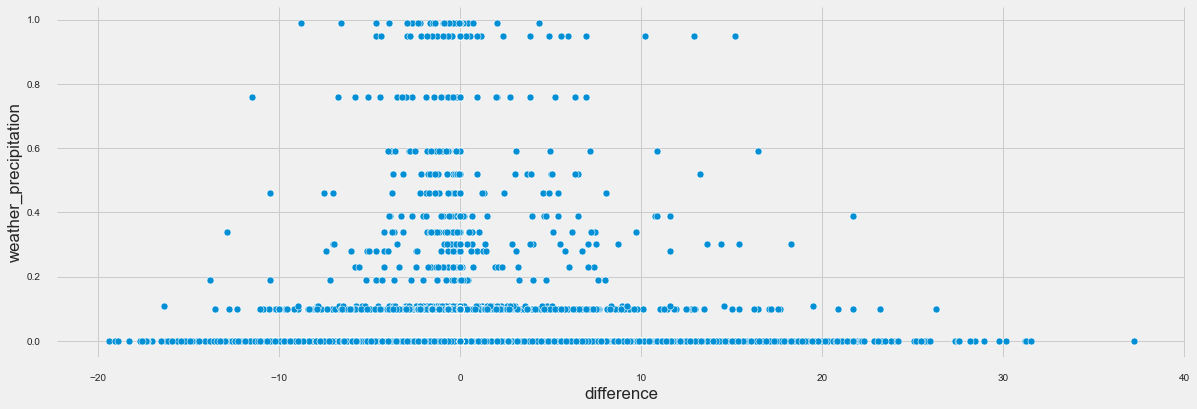

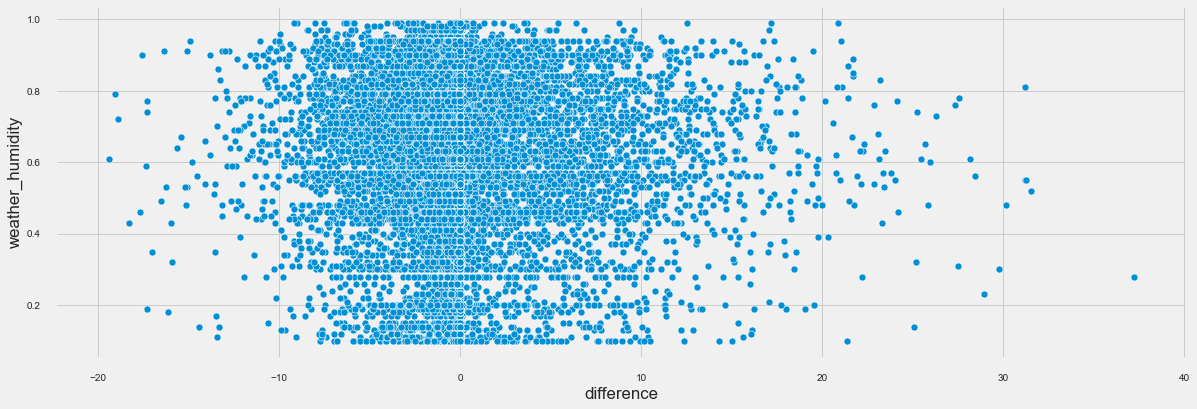

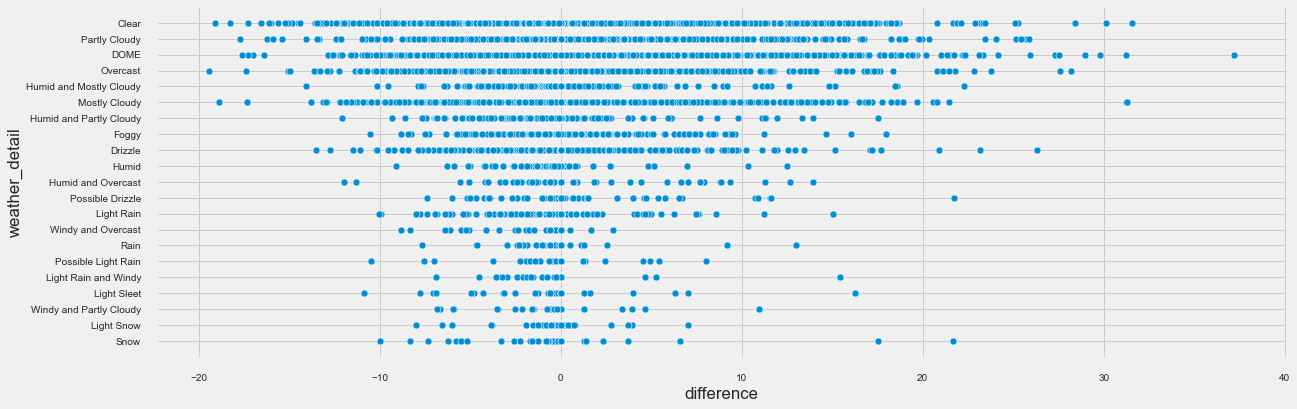

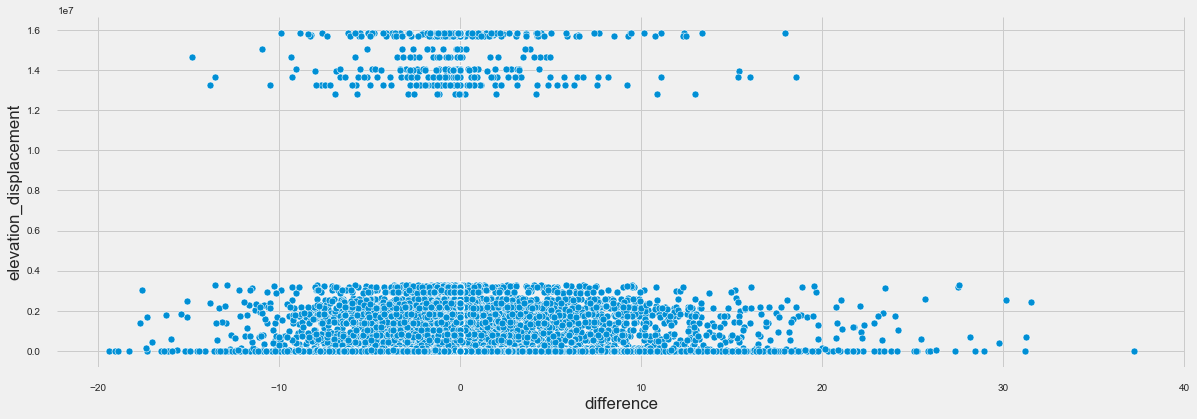

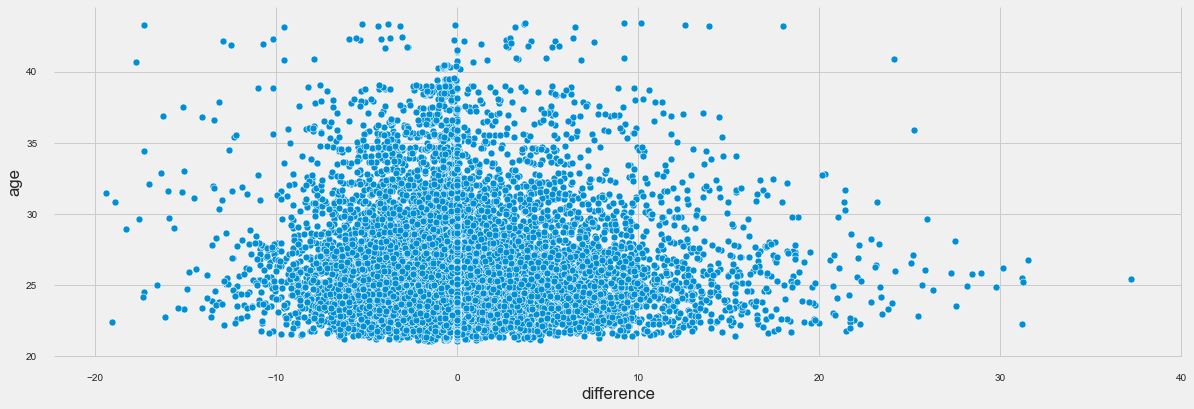

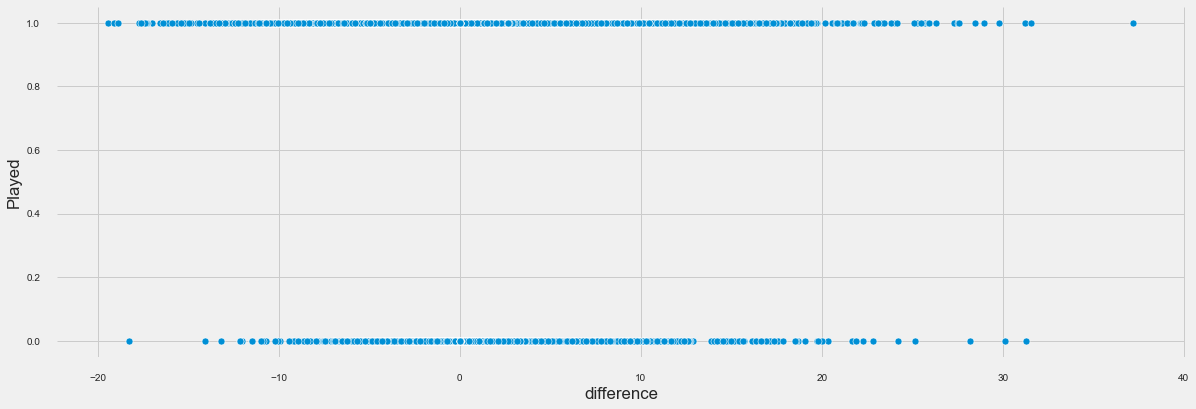

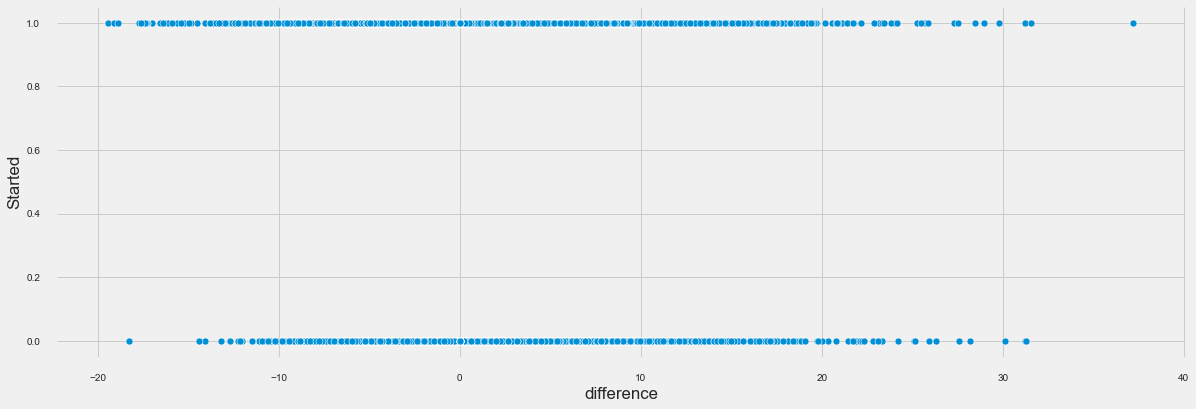

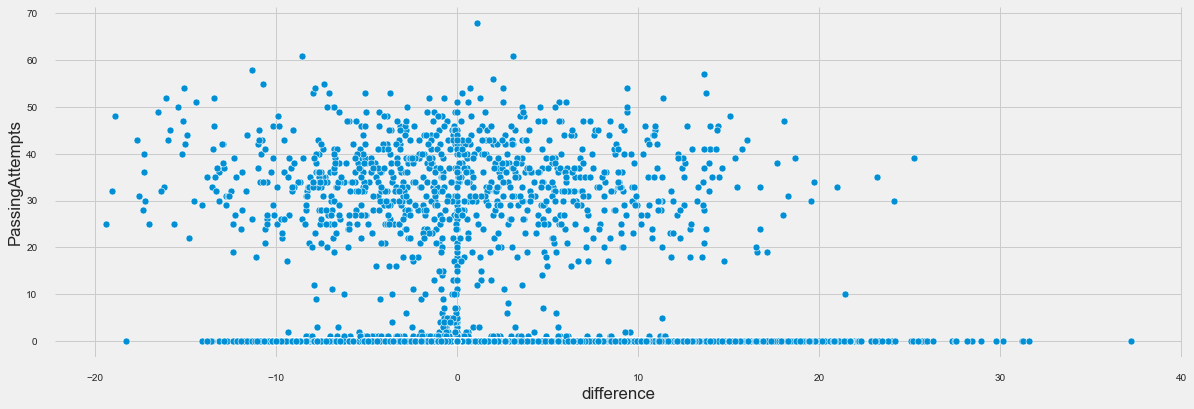

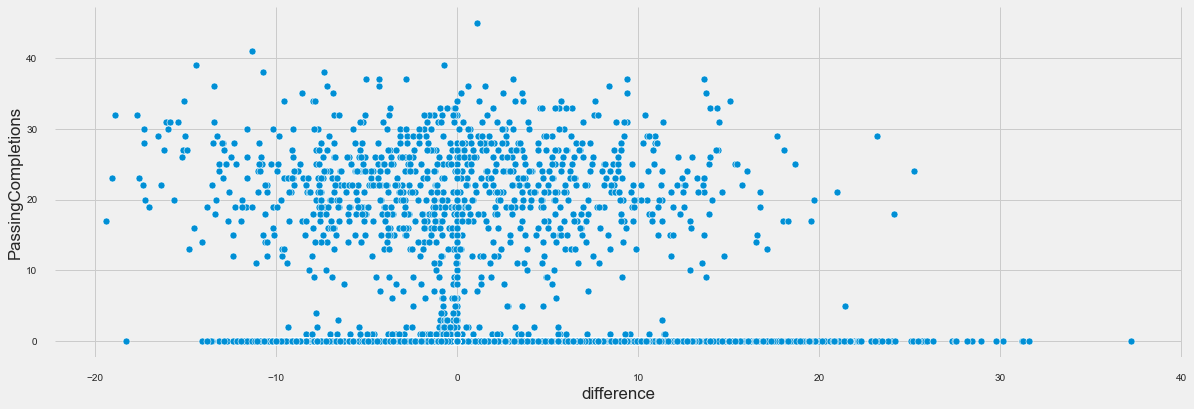

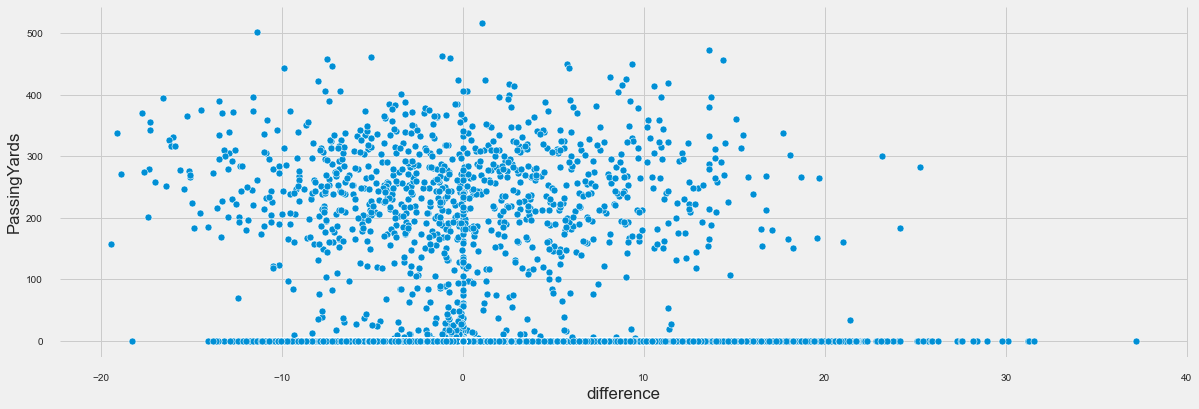

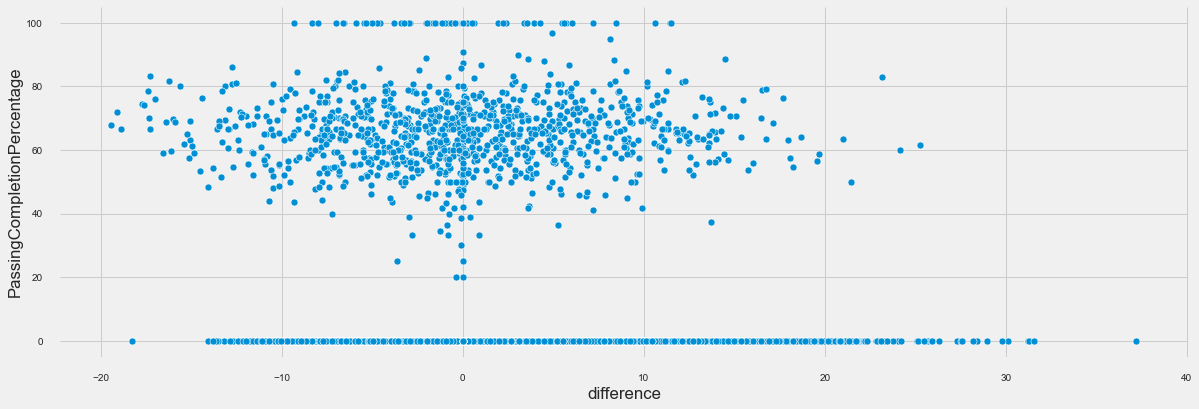

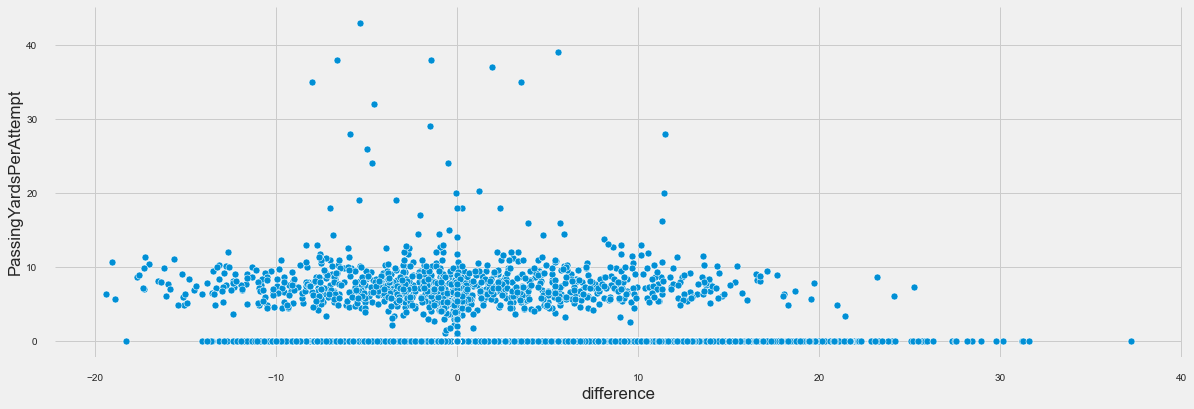

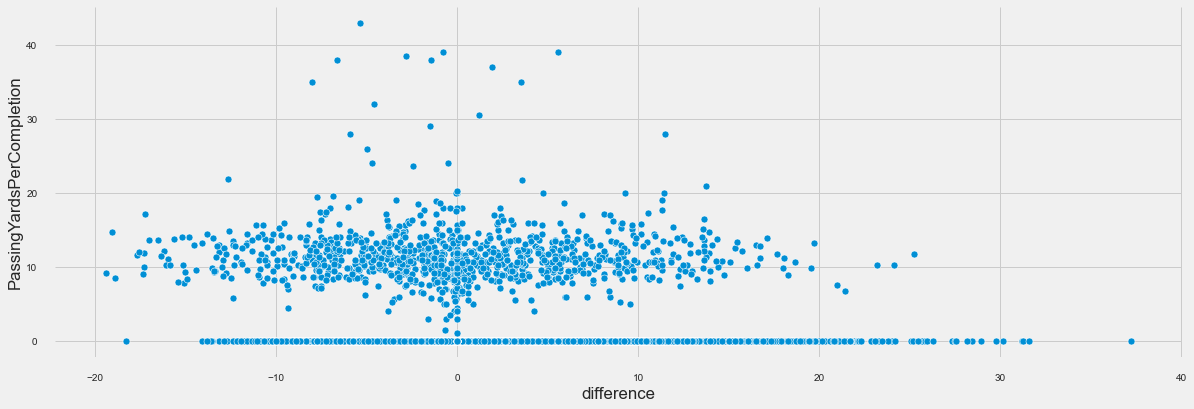

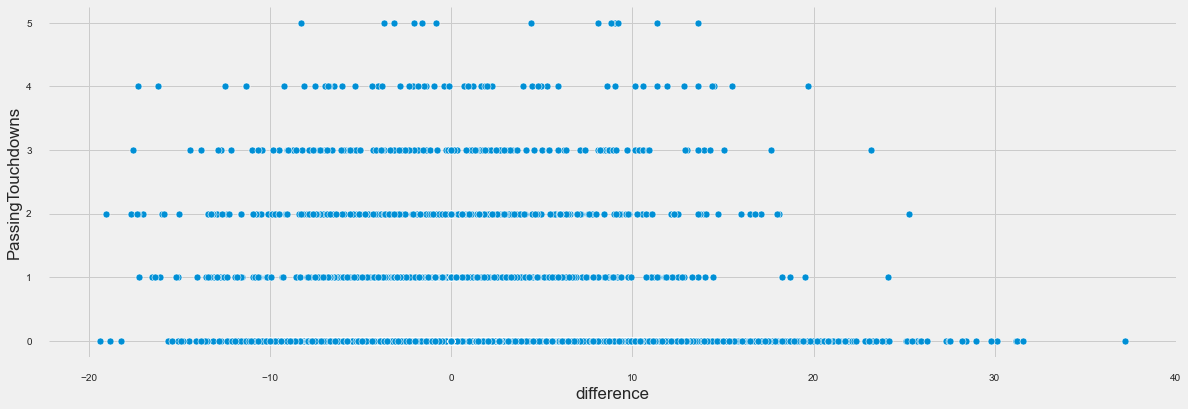

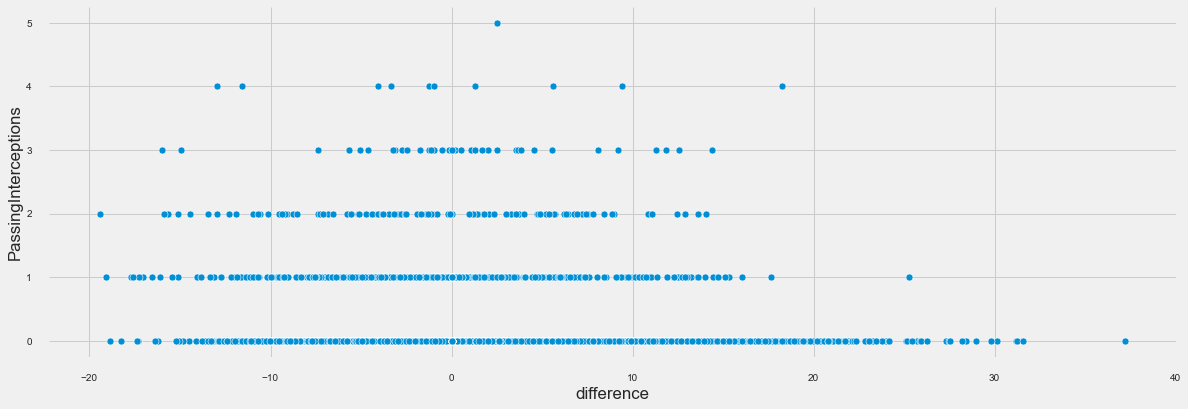

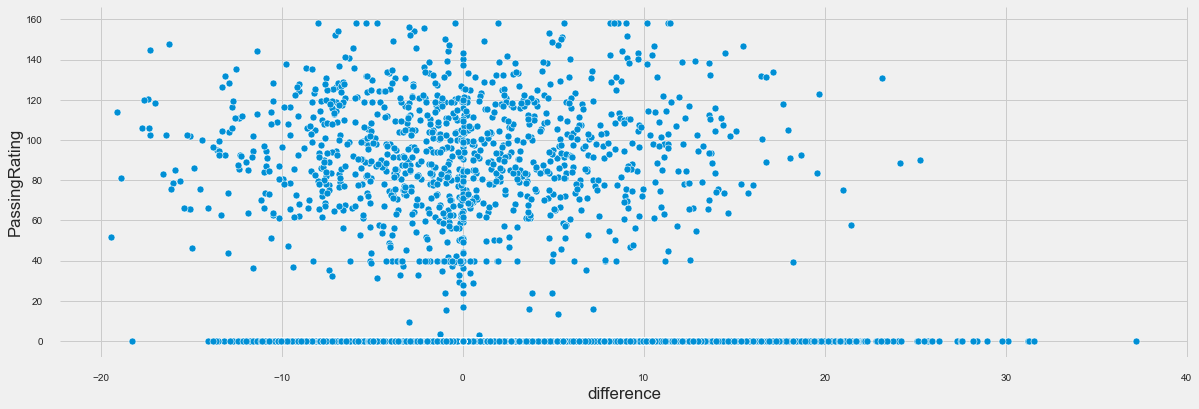

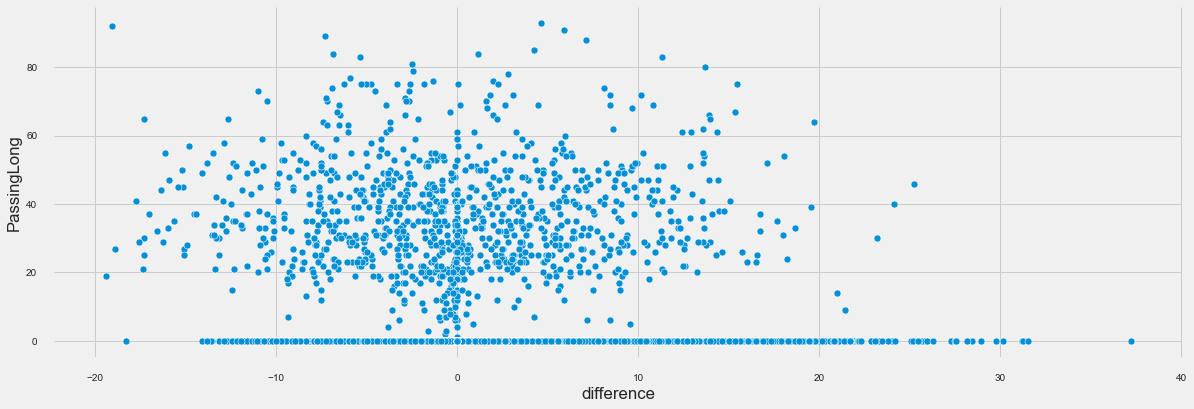

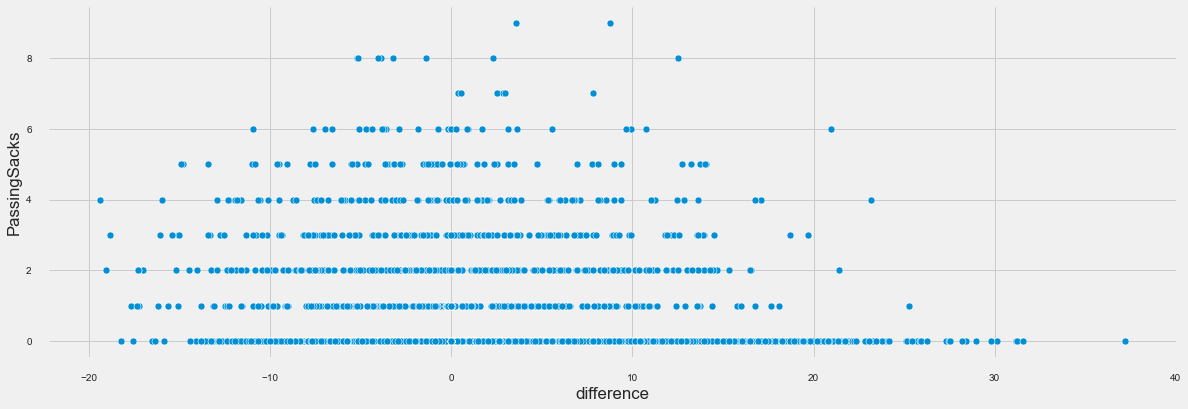

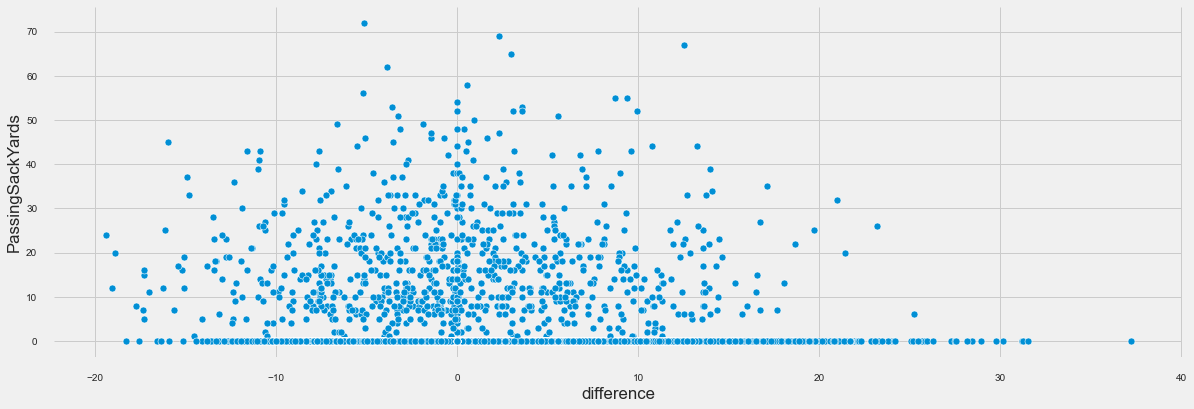

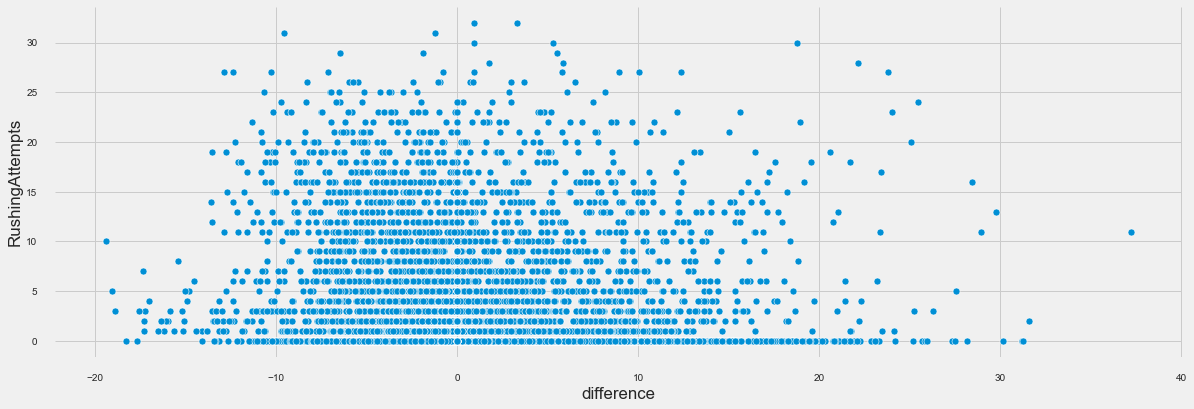

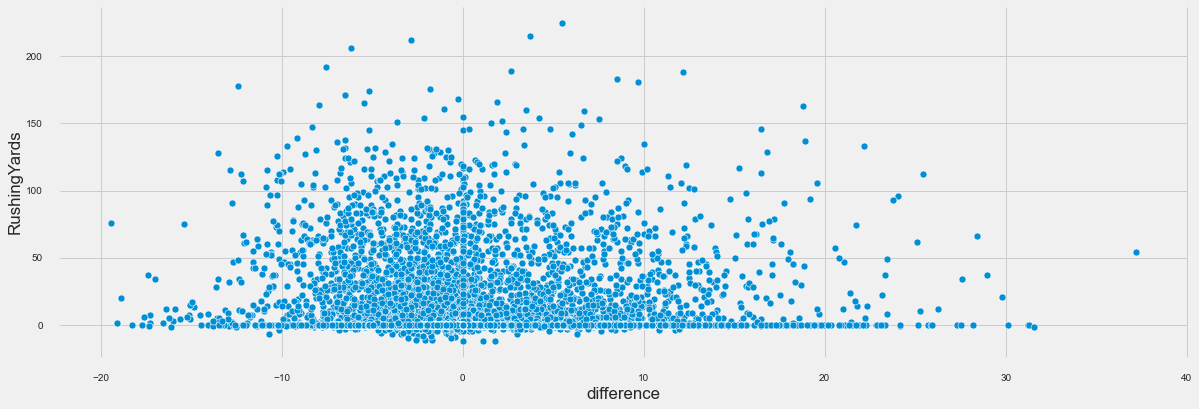

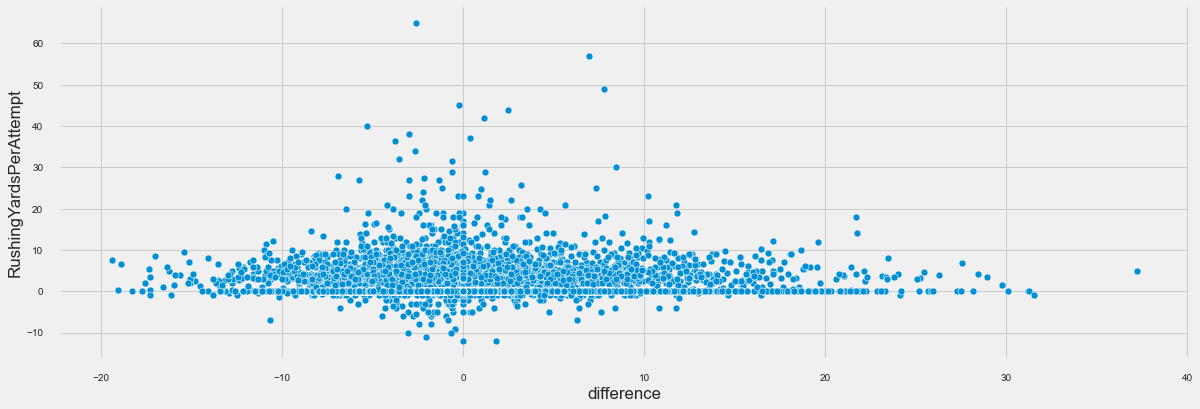

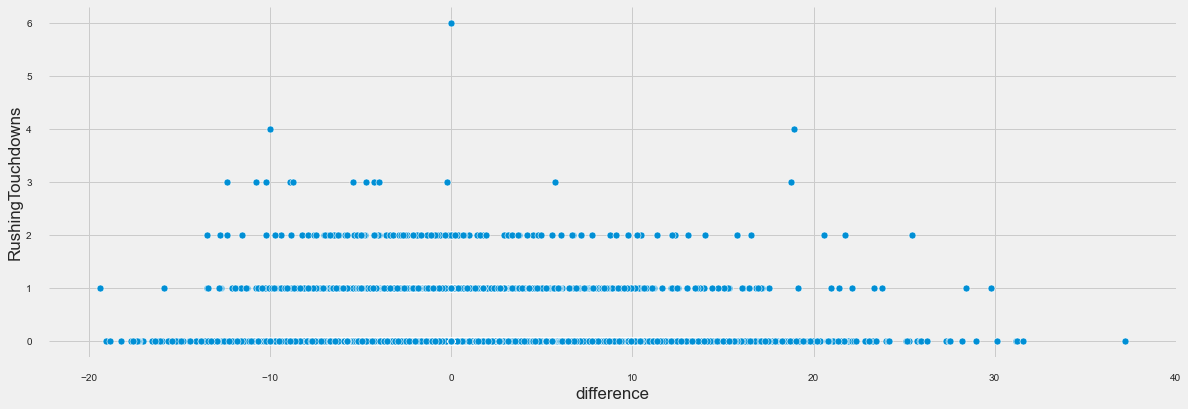

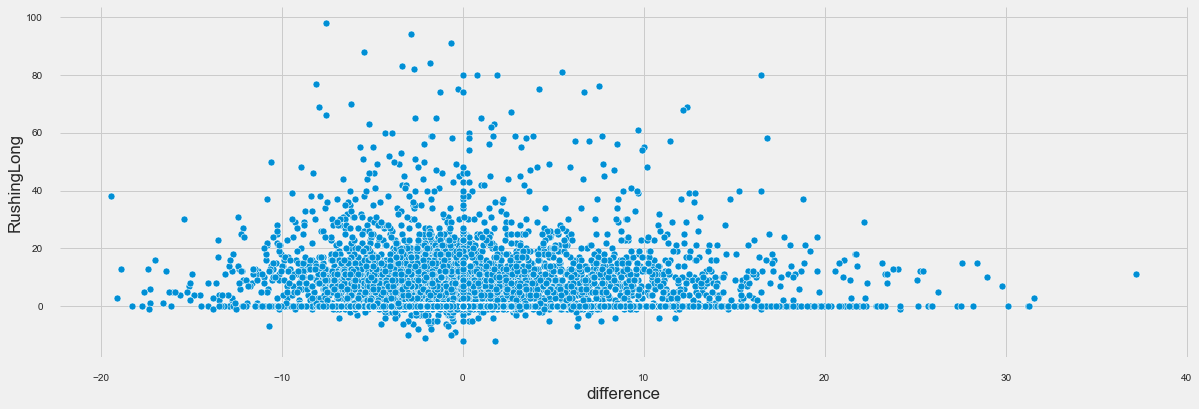

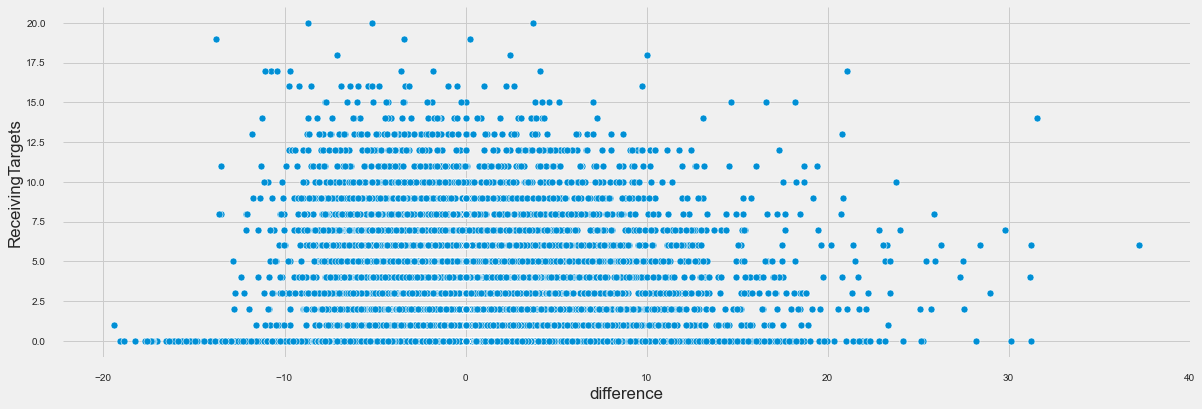

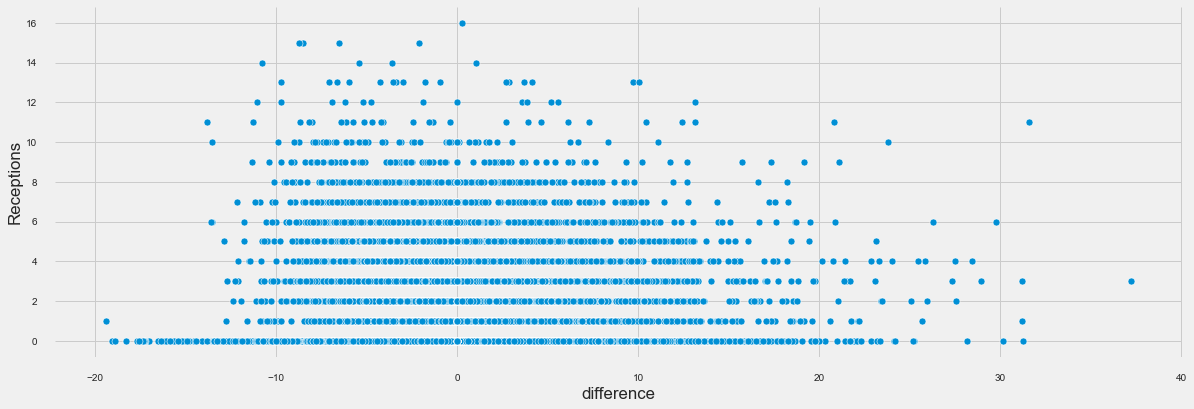

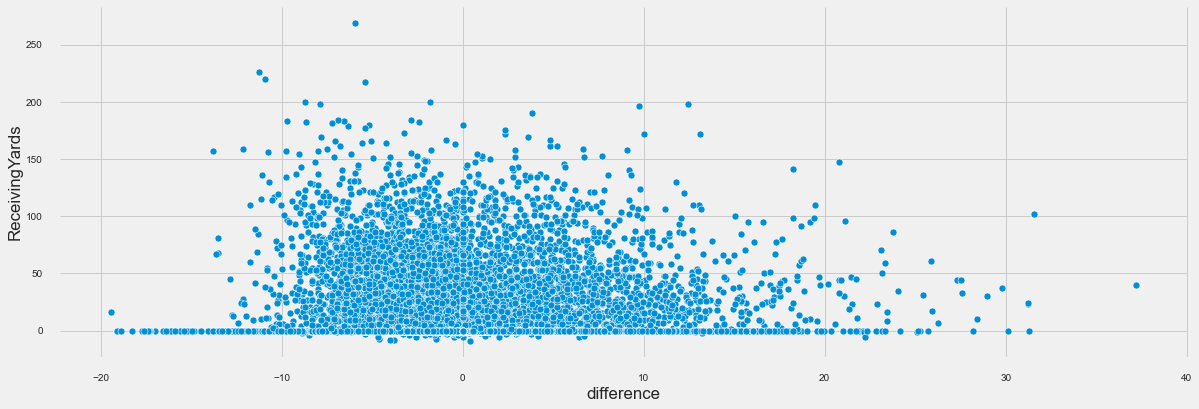

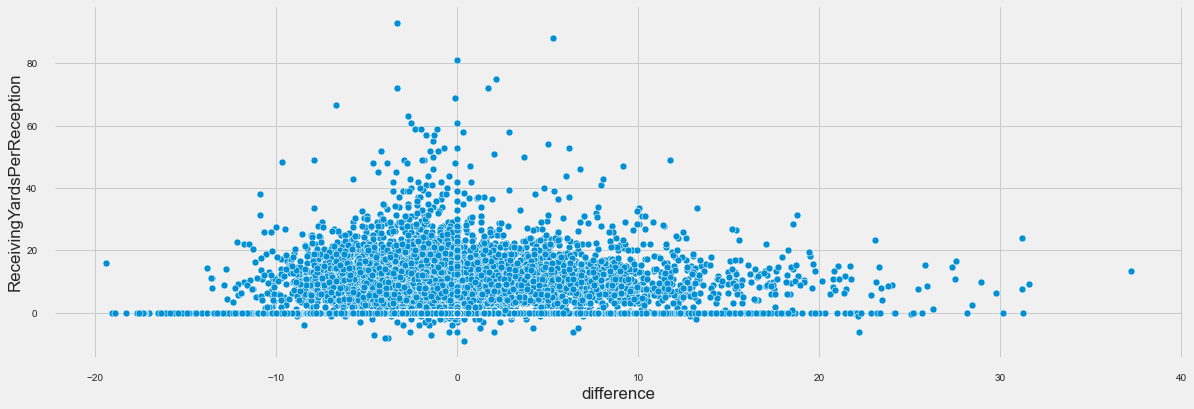

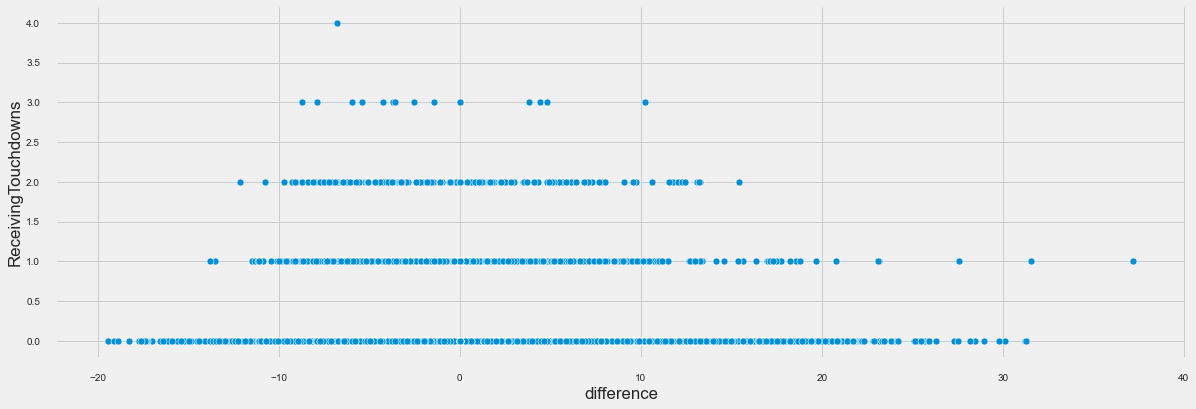

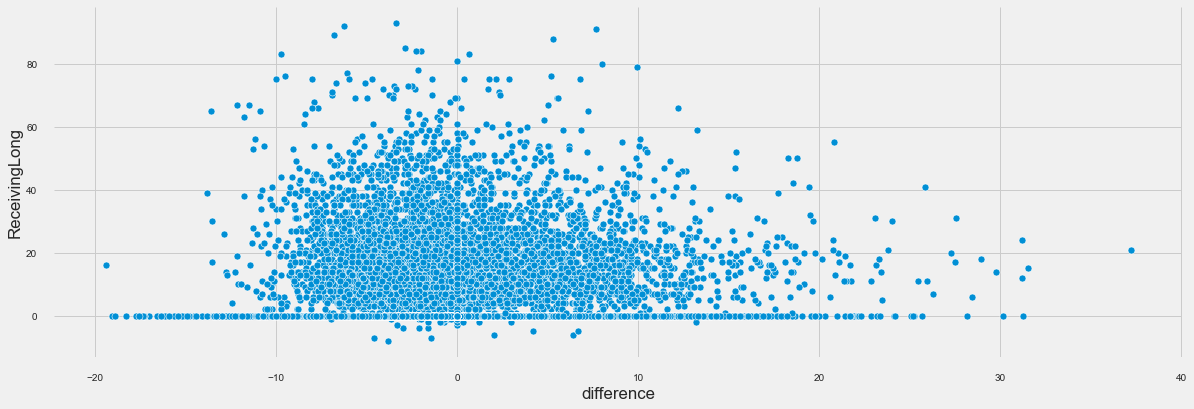

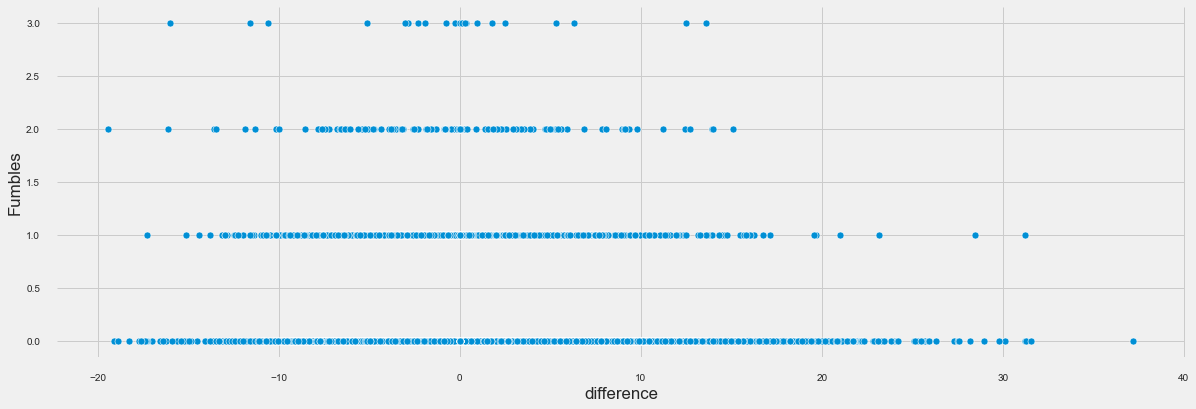

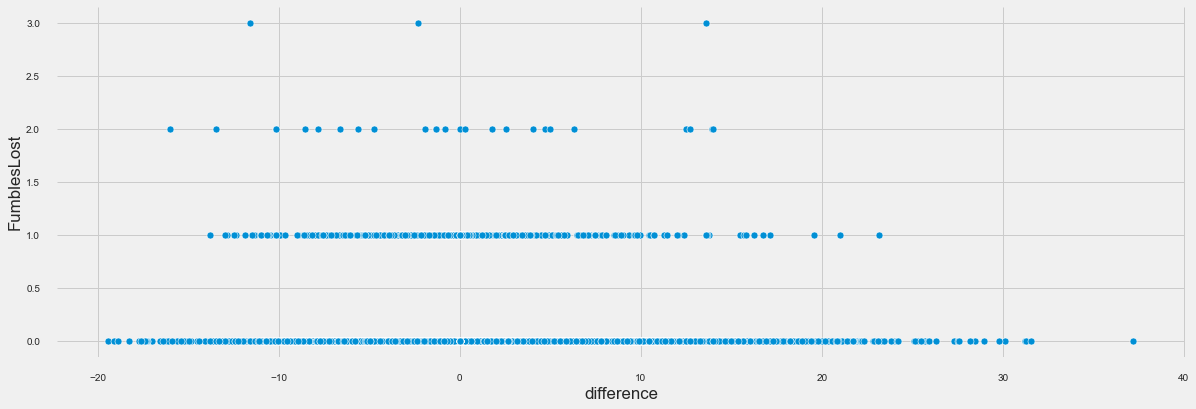

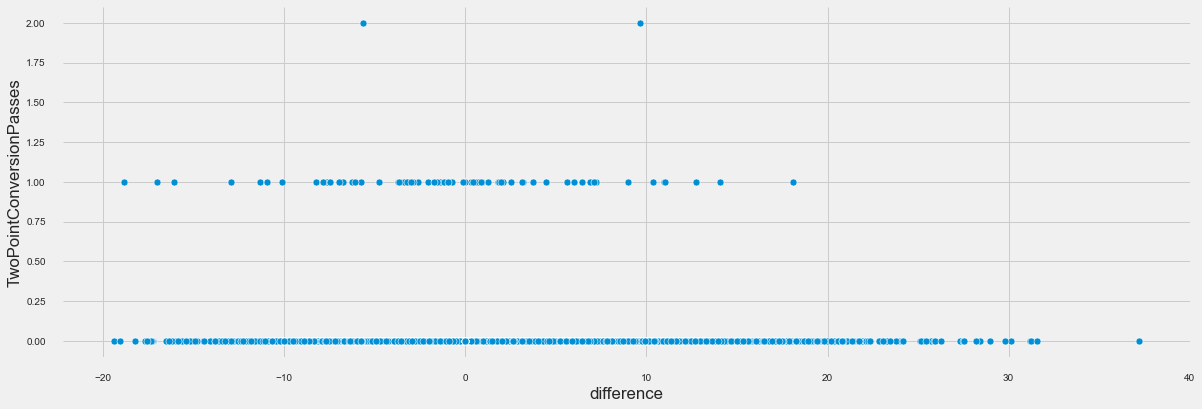

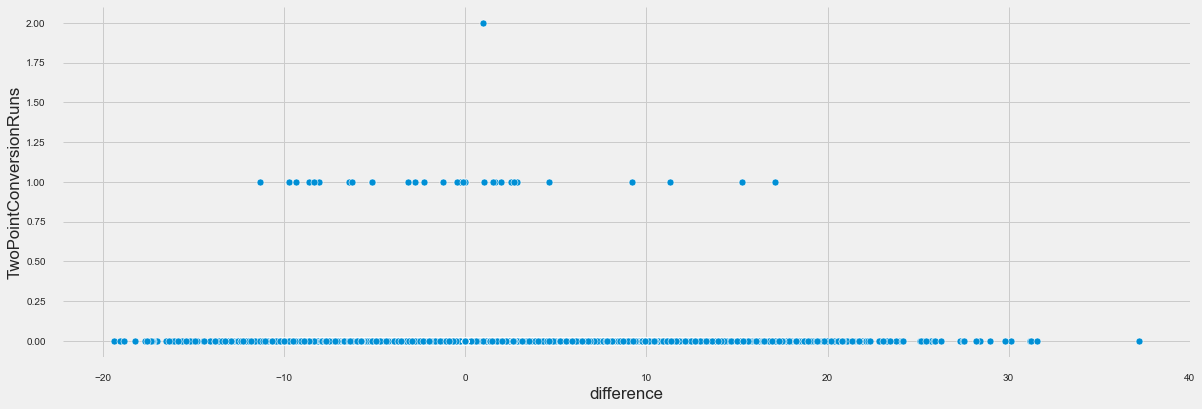

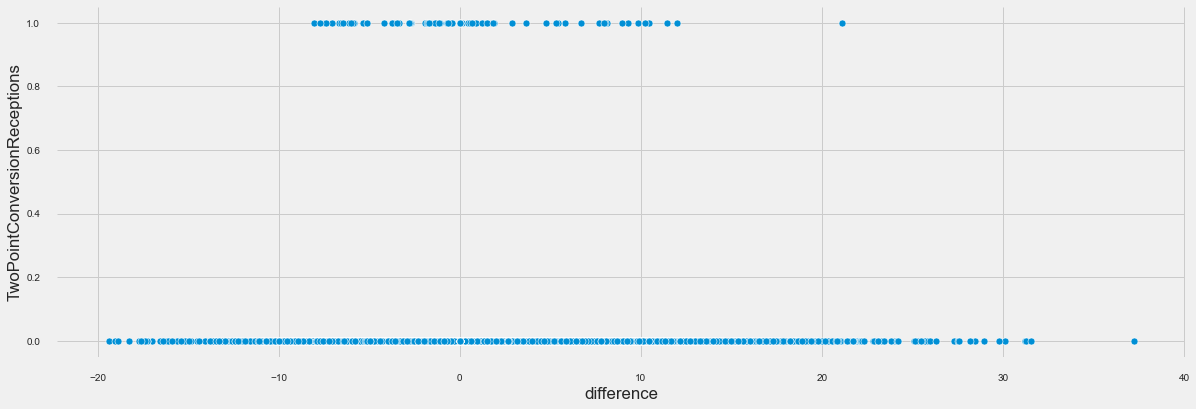

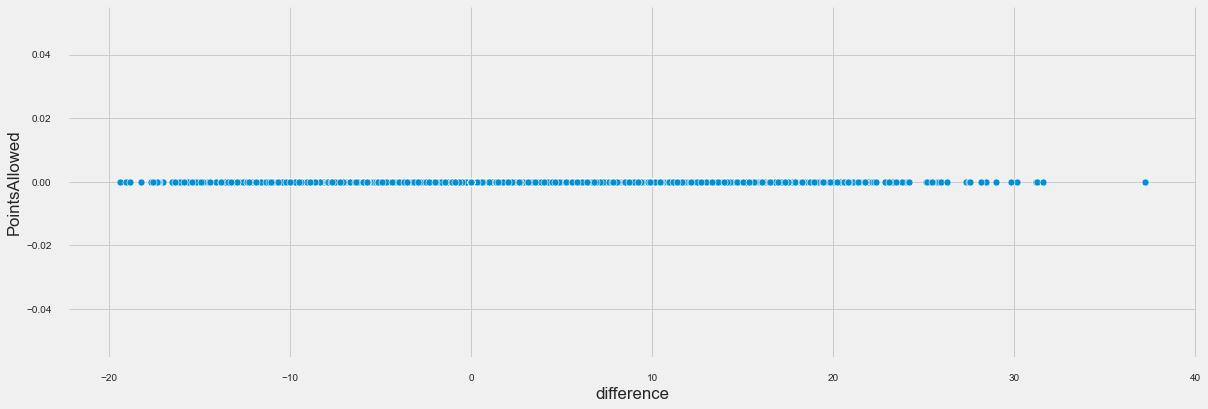

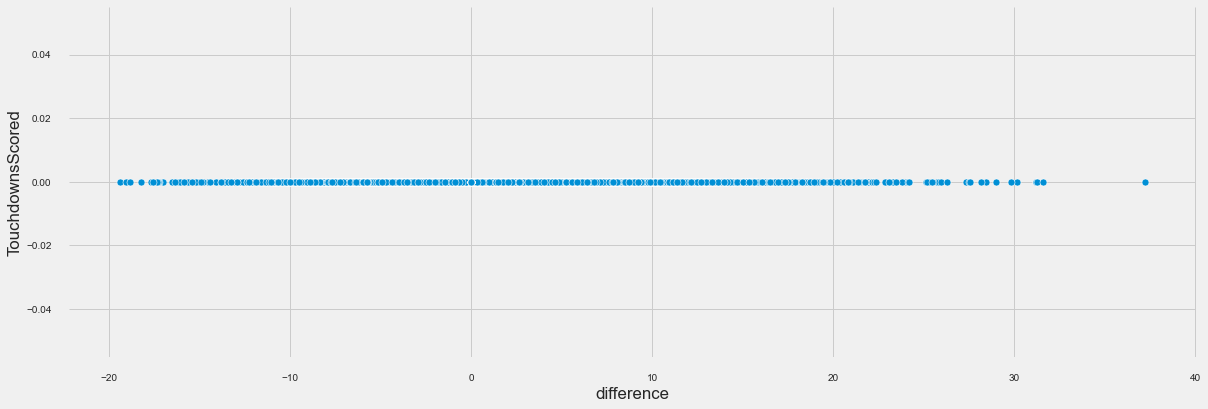

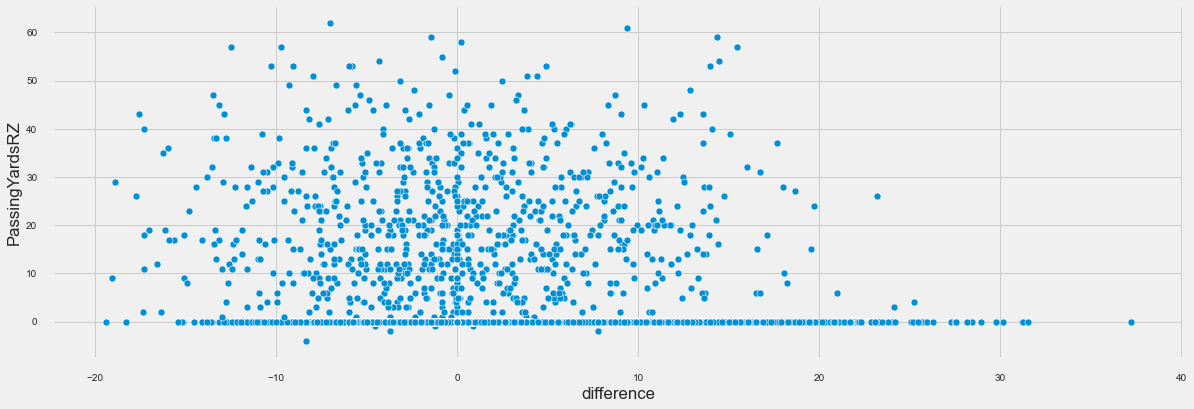

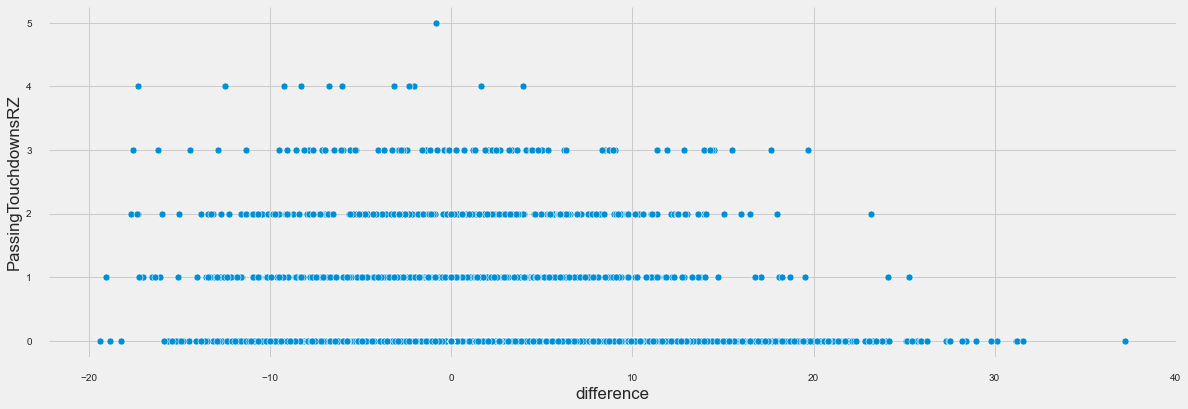

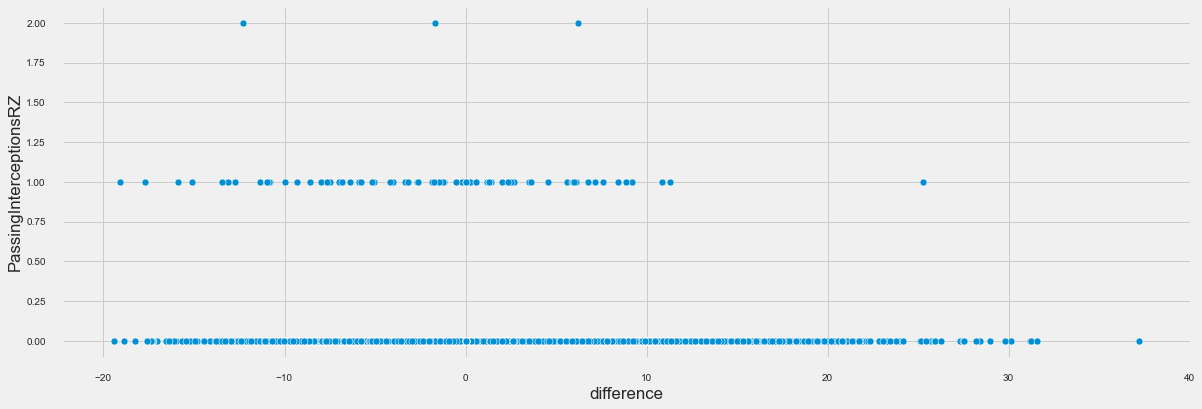

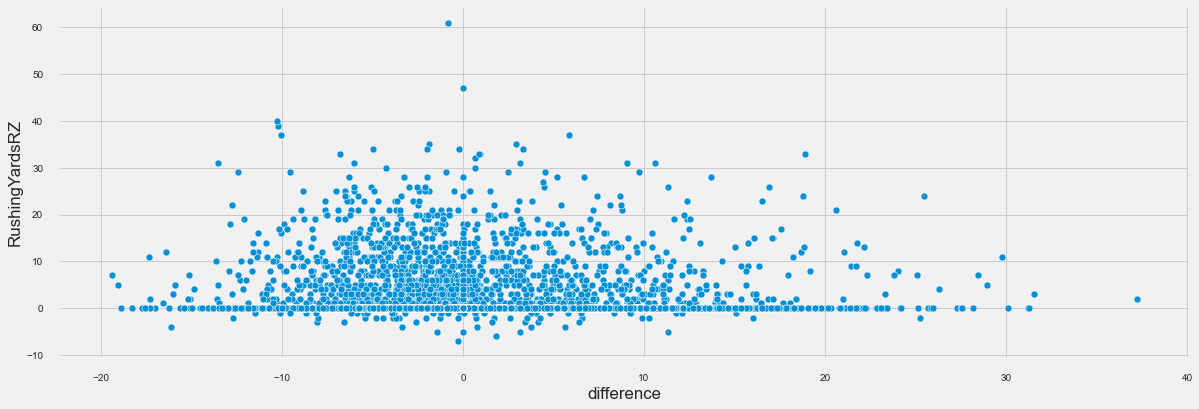

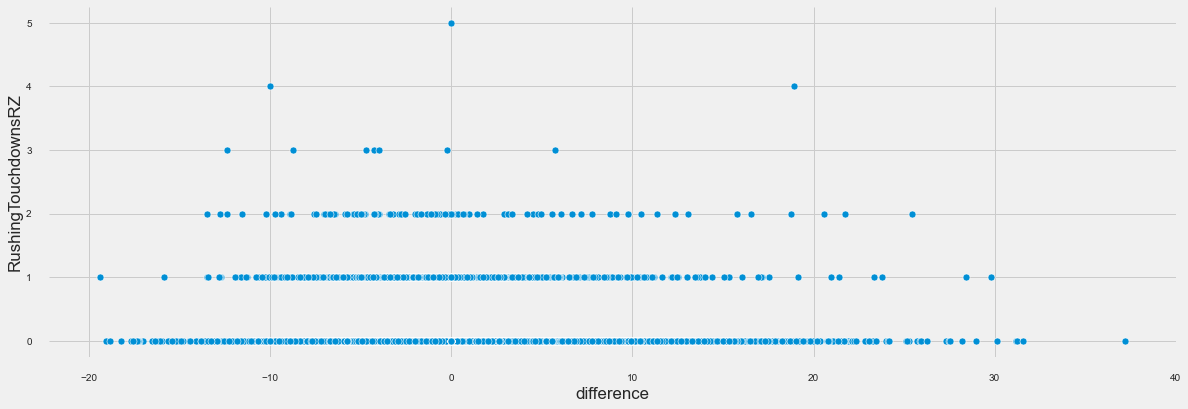

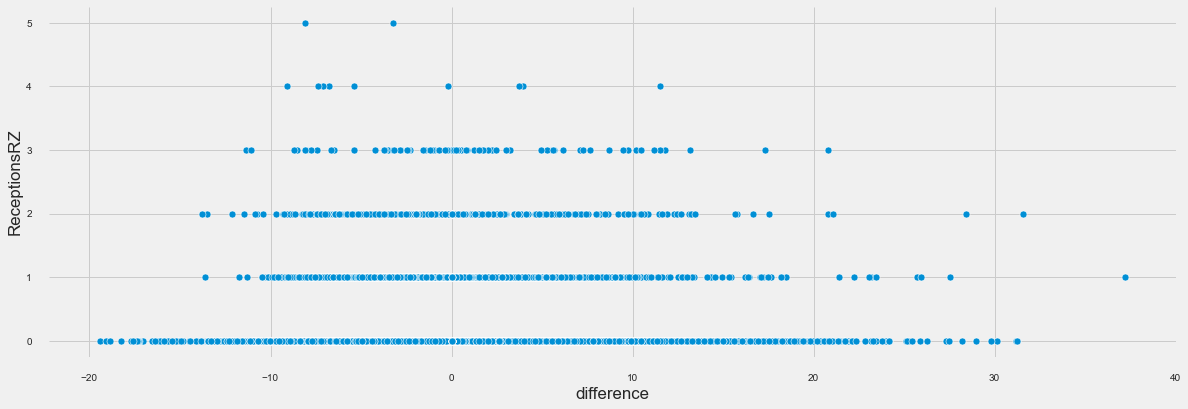

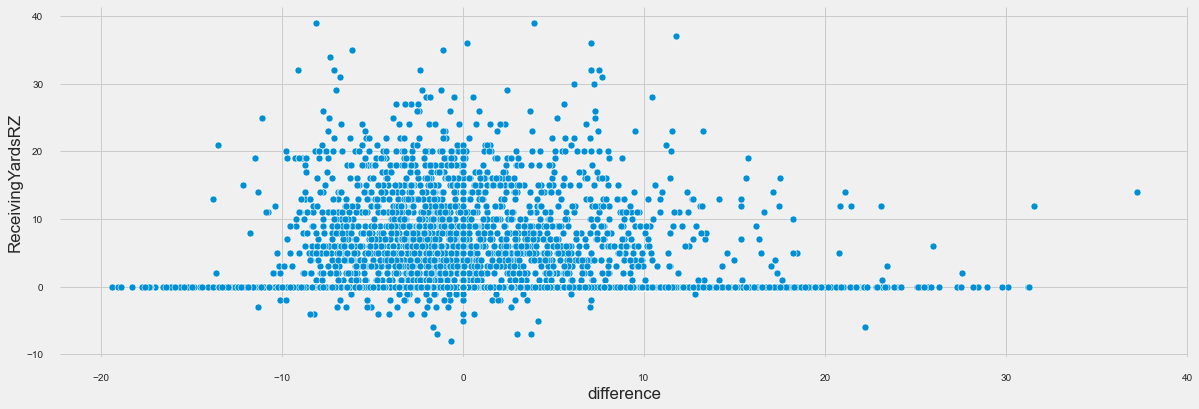

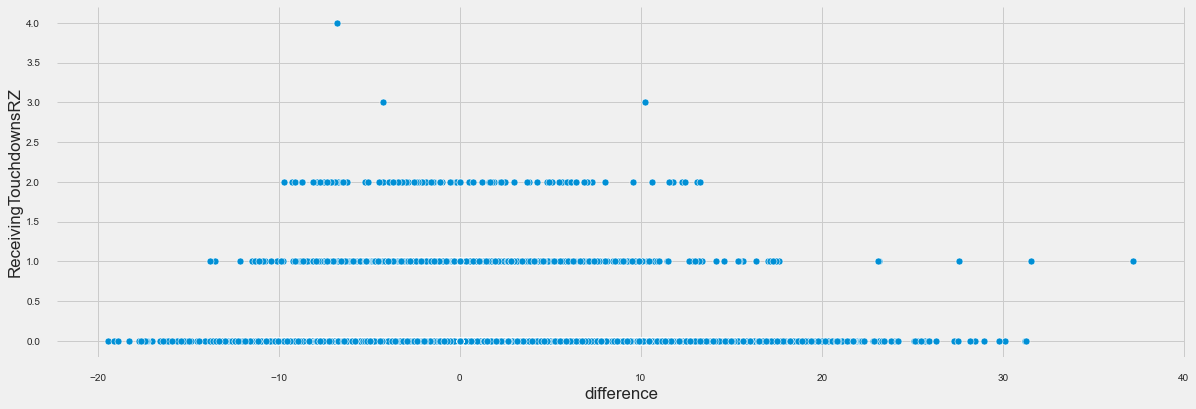

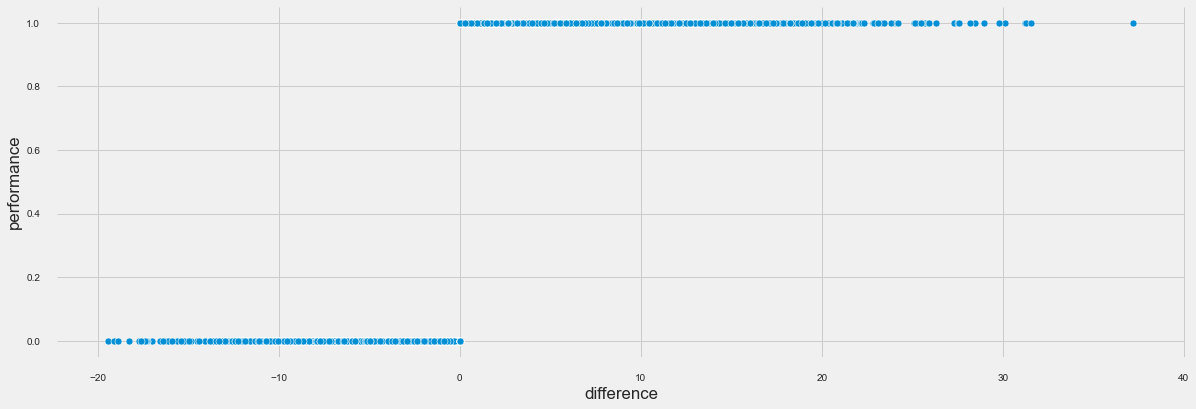

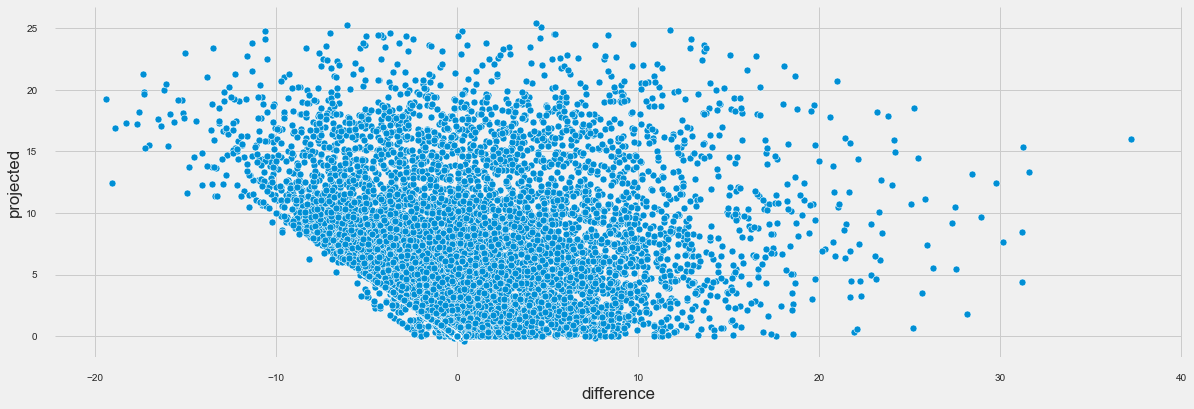

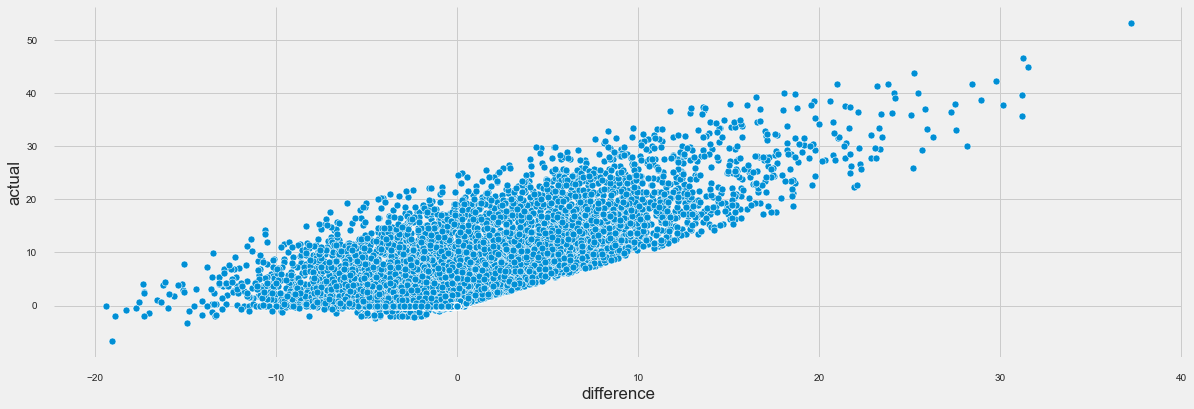

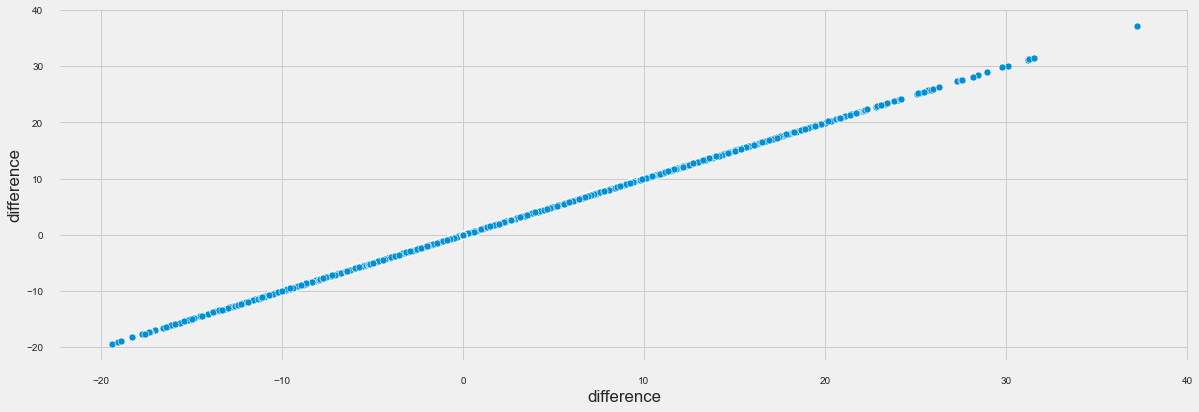

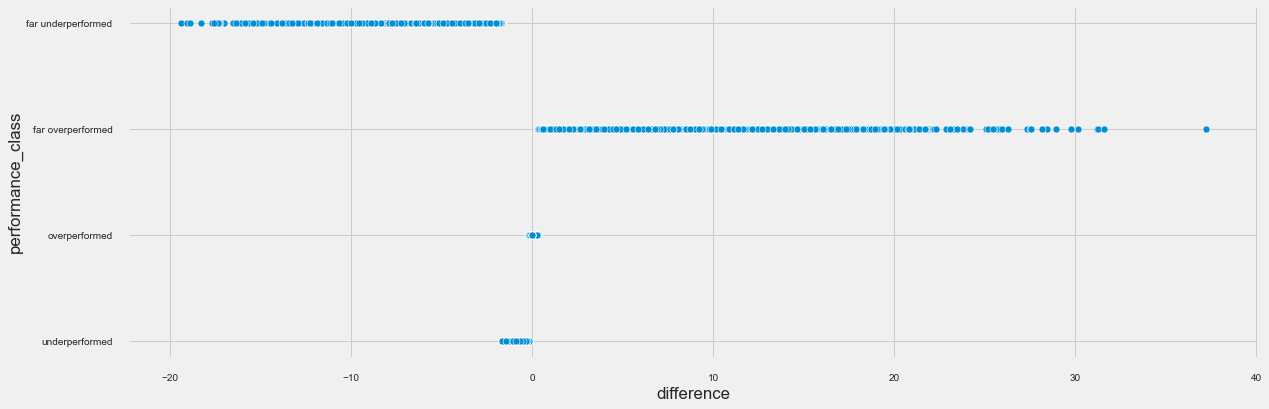

In [13]:
for col in df.columns[2:len(df.columns)]:
    
    sns.scatterplot(x = 'difference', y = col, palette=['b','r'], data=df)
    sns.despine(offset=10, trim=True)

    plt.show()
    plt.clf()

plt.close()

In [14]:
df.describe()

GameKey      PlayerID          Week  InjuryStatus        TeamID  \
count  1.705400e+04  17054.000000  17054.000000  17054.000000  17054.000000   
mean   2.019617e+08  18034.528615      9.101091      0.042395     17.993374   
std    5.000307e+04   3769.935582      5.019832      0.201494     10.420498   
min    2.019101e+08    611.000000      1.000000      0.000000      1.000000   
25%    2.019109e+08  16765.000000      5.000000      0.000000      9.000000   
50%    2.020101e+08  19029.000000      9.000000      0.000000     19.000000   
75%    2.020109e+08  20743.000000     14.000000      0.000000     28.000000   
max    2.020117e+08  22477.000000     17.000000      1.000000     35.000000   

         OpponentID       ScoreID  days_since_last_game  \
count  17054.000000  17054.000000          17054.000000   
mean      17.761522  17258.161663             26.320629   
std       10.468028    165.612790             74.571611   
min        1.000000  16983.000000              4.000000   
25%        8.000000  17113.000000              7.000000   
50%       19.000000  17266.000000              7.000000   
75%       28.000000  17402.000000              8.000000   
max       35.000000  17645.000000            365.000000   

       absolute_hours_displaced  weather_temperature  weather_wind_mph_number  \
count              17054.000000         17054.000000             17054.000000   
mean                   0.506450            62.593409                 4.893749   
std                    0.906488            15.348812                 4.440842   
min                    0.000000            13.000000                 0.000000   
25%                    0.000000            51.000000                 0.000000   
50%                    0.000000            68.000000                 4.000000   
75%                    1.000000            72.000000                 7.000000   
max                    3.000000            95.000000                26.000000   

       weather_cloud_cover  weather_precipitation  weather_humidity  \
count         17054.000000           17054.000000      17054.000000   
mean              0.393779               0.018742          0.621108   
std               0.314585               0.087106          0.208705   
min               0.000000               0.000000          0.100000   
25%               0.100000               0.000000          0.490000   
50%               0.320000               0.000000          0.640000   
75%               0.670000               0.000000          0.780000   
max               0.990000               0.990000          0.990000   

       elevation_displacement           age        Played       Started  \
count            1.705400e+04  17054.000000  17054.000000  17054.000000   
mean             1.051184e+06     26.414752      0.695379      0.314941   
std              2.599864e+06      3.488004      0.460260      0.464506   
min              0.000000e+00     21.083367      0.000000      0.000000   
25%              0.000000e+00     23.975433      0.000000      0.000000   
50%              1.225000e+03     25.677542      1.000000      0.000000   
75%              1.387850e+06     27.816173      1.000000      1.000000   
max              1.585337e+07     43.421950      1.000000      1.000000   

       PassingAttempts  PassingCompletions  PassingYards  \
count     17054.000000        17054.000000  17054.000000   
mean          1.956843            1.264395     14.192682   
std           8.136315            5.300421     60.111503   
min           0.000000            0.000000      0.000000   
25%           0.000000            0.000000      0.000000   
50%           0.000000            0.000000      0.000000   
75%           0.000000            0.000000      0.000000   
max          68.000000           45.000000    517.000000   

       PassingCompletionPercentage  PassingYardsPerAttempt  \
count                 17054.000000            17054.000000   
mean                      4.229805                0.49216

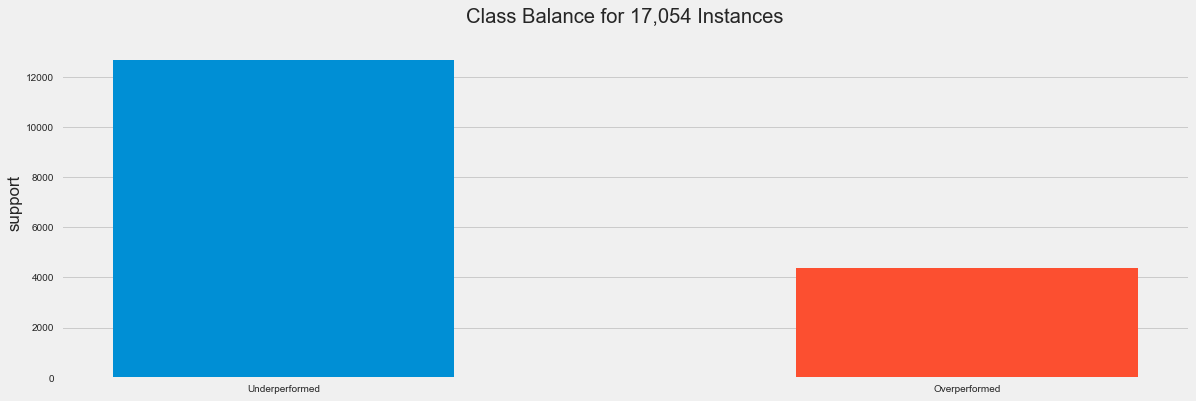

In [15]:
y = df['performance']
visualizer = ClassBalance(labels=['Underperformed','Overperformed'])

visualizer.fit(y) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

# Prepping data to fit and run models

In [16]:
# Split dataframe into two dataframes: X will have all but target, y will have target
X = df.drop([
    'performance',
    'performance_class',
    'projected',
    'actual',
    'difference',
    'GameKey',
    'TeamID',
    'OpponentID',
    'ScoreID',
    'GameKey',
    'PlayerID',
    'TeamID',
    'OpponentID',
    'ScoreID',
    'week_id'
], axis = 'columns')

y = df['performance']

In [17]:
categorical = make_column_selector(dtype_include=object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)

In [18]:
# list of models to use
models = [
    SVC(),
    NuSVC(),
    LinearSVC(),
    SGDClassifier(),
    KNeighborsClassifier(),
    LogisticRegression(),
    LogisticRegressionCV(),
    BaggingClassifier(),
    ExtraTreesClassifier(),
    RandomForestClassifier()
]

In [19]:
# function to score models
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    
    # handle_unknown='ignore' in OneHotEncoder() is used because weather_detail data gave it trouble
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scalar', MinMaxScaler(), numeric),
        ('scalar2', MinMaxScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('estimator', estimator)
    ])

    #add train/test split (train 14 weeks and below, test above 14 weeks)
    y_train = y[:X.index[X['Week'] > 14].tolist()[0]]
    y_test = y[X.index[X['Week'] > 14].tolist()[0]:]
    X_train = X[:X.index[X['Week'] > 14].tolist()[0]].drop('Week', axis = 'columns')
    X_test = X[X.index[X['Week'] > 14].tolist()[0]:].drop('Week', axis = 'columns')
    
    # Instantiate the classification model and visualizer
    model.fit(X_train, y_train, **kwargs) #updated to train with train set
    expected  = y_test #updated with test set
    predicted = model.predict(X_test)  #updated with test set
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [20]:
# function to visualize models
def visualize_model(X, y, estimator, **kwargs):
    """
    Visualizes models
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scalar', MinMaxScaler(), numeric),
        ('scalar2', MinMaxScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
    ])
    
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['Underperformed', 'Overperformed'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    
    
    #add train/test split (train 14 weeks and below, test above 14 weeks)
    y_train = y[:X.index[X['Week'] > 14].tolist()[0]]
    y_test = y[X.index[X['Week'] > 14].tolist()[0]:]
    X_train = X[:X.index[X['Week'] > 14].tolist()[0]].drop('Week', axis = 'columns')
    X_test = X[X.index[X['Week'] > 14].tolist()[0]:].drop('Week', axis = 'columns')
    
    visualizer.fit(X_train, y_train) #updated with train set
    visualizer.score(X_test, y_test) #updated with test set
    visualizer.show()

# Scoring and Visualization of Models

F1 SCORE SVC: 0.5667090216010167


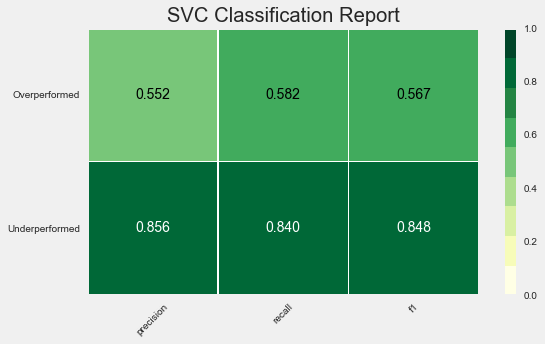

F1 SCORE NuSVC: 0.5831381733021078


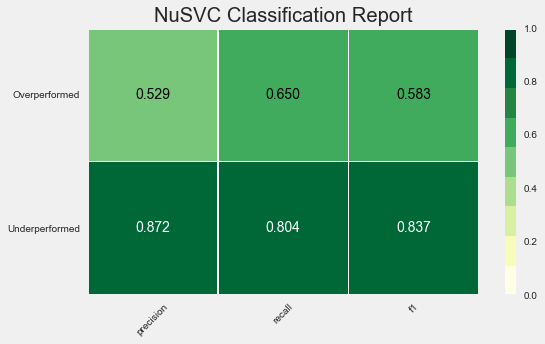

F1 SCORE LinearSVC: 0.5253333333333333


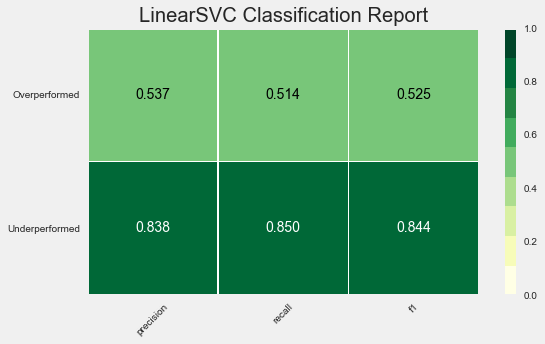

F1 SCORE SGDClassifier: 0.5880952380952381


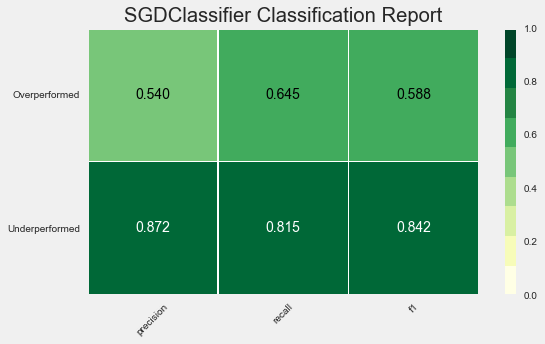

F1 SCORE KNeighborsClassifier: 0.38513513513513514


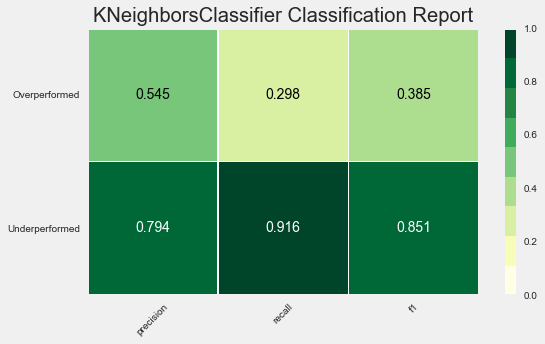

C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 SCORE LogisticRegression: 0.5155195681511471


C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


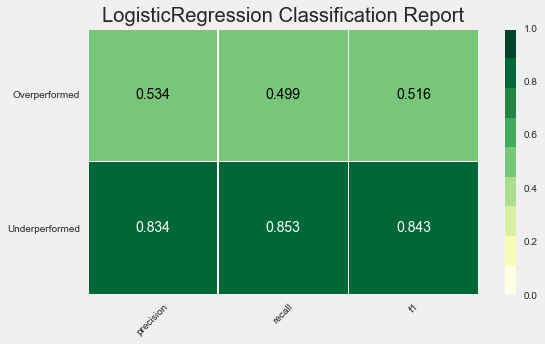

C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

F1 SCORE LogisticRegressionCV: 0.5212765957446808


C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

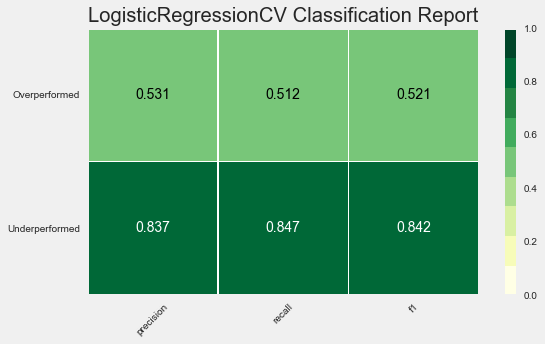

F1 SCORE BaggingClassifier: 0.41587301587301584


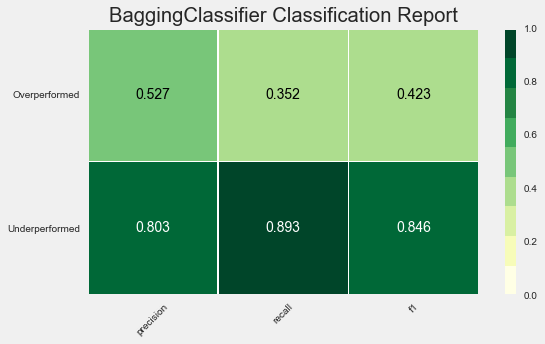

F1 SCORE ExtraTreesClassifier: 0.4572271386430679


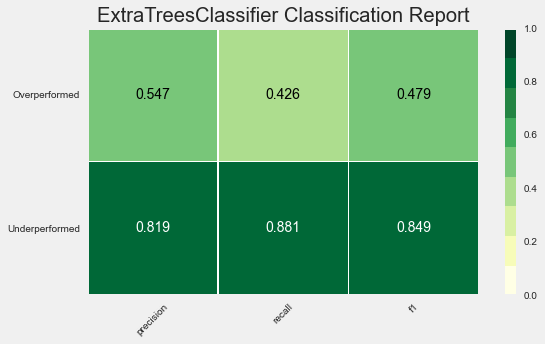

F1 SCORE RandomForestClassifier: 0.47813411078717194


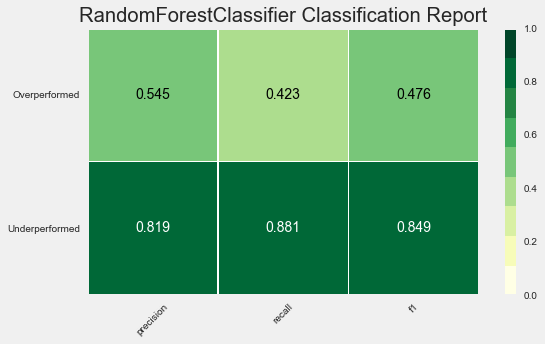

In [21]:
for model in models:
    score_model(X, y, model)
    visualize_model(X, y, model)

# Parameter Tuning

In [22]:
# list of models to use
modified_models = [
    SVC(gamma = 'auto'),
    NuSVC(gamma = 'auto'),
    LinearSVC(max_iter = 2000),
    SGDClassifier(max_iter = 100, tol = 1e-3),
    KNeighborsClassifier(n_neighbors = 10),
    LogisticRegression(solver = 'lbfgs'),
    LogisticRegressionCV(cv=3, max_iter=100),
    BaggingClassifier(n_estimators = 15),
    ExtraTreesClassifier(n_estimators = 300),
    RandomForestClassifier(n_estimators = 300)
]

F1 SCORE SVC: 0.5831381733021078


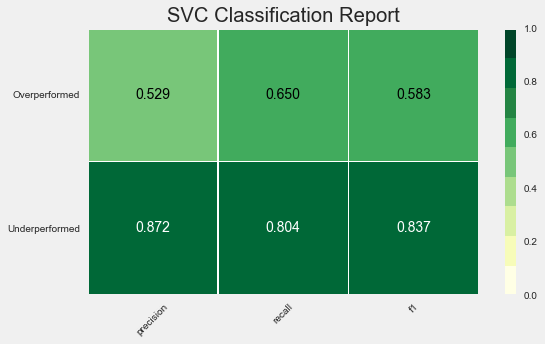

F1 SCORE NuSVC: 0.5831381733021078


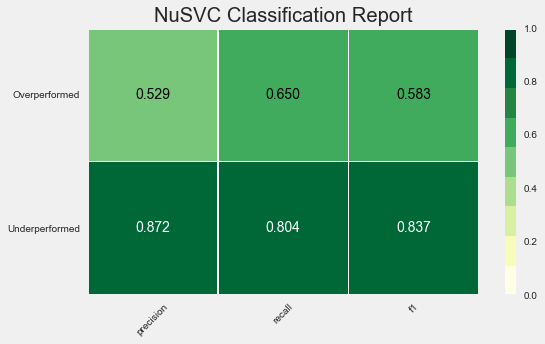

F1 SCORE LinearSVC: 0.5253333333333333


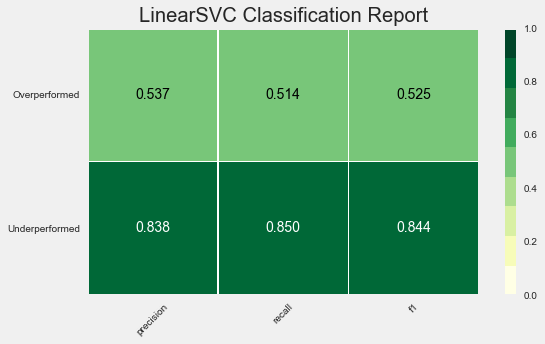

F1 SCORE SGDClassifier: 0.5800240673886884


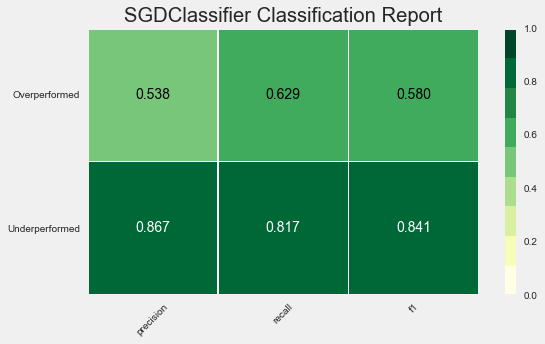

F1 SCORE KNeighborsClassifier: 0.24596774193548385


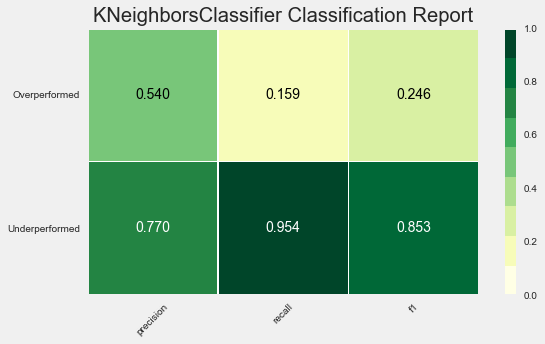

C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 SCORE LogisticRegression: 0.5155195681511471


C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


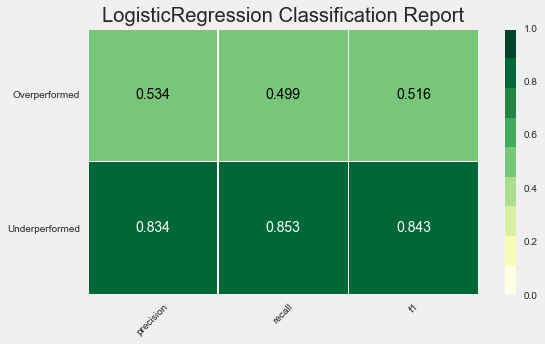

C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

F1 SCORE LogisticRegressionCV: 0.5212765957446808


C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

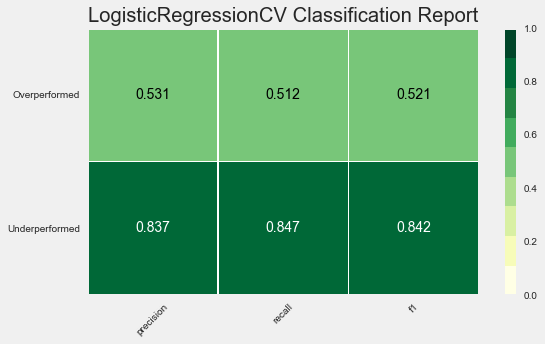

F1 SCORE BaggingClassifier: 0.463810930576071


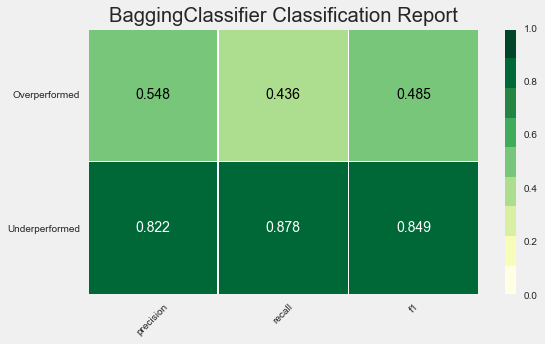

F1 SCORE ExtraTreesClassifier: 0.49785407725321884


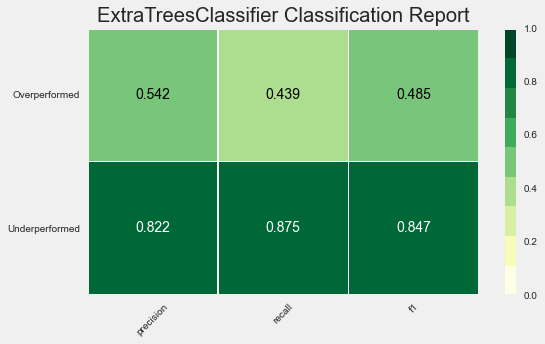

F1 SCORE RandomForestClassifier: 0.4948453608247423


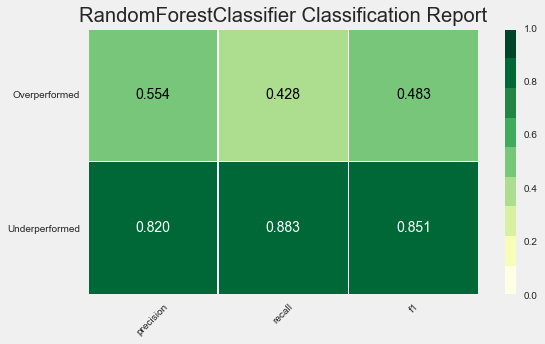

In [23]:
# iterate through list of models through both functions defined above
# Use X and y dataframes first, which contain all of the data
for model in modified_models:
    score_model(X, y, model)
    visualize_model(X, y, model)

# Review Scores of default and tuned models

all models with over .5 recall for the overperformed class
SVC Classification Overperformed Recall = .65
NuSVC Classification Overperformed Recall = .65
SGDClassifier Classification Overperformed Recall = .637
LinearSVC Classification Overperformed Recall = .514
LogisticRegressionCV Classification Overperformed Recall = .512

Next steps: account for class imbalance by penalizing models for making mistakes when predicting the minority class. Credit to this article for this quote explaining penalty:

During training, we can use the argument class_weight='balanced' to penalize mistakes on the minority class by an amount proportional to how under-represented it is.

In [24]:
final_models = [
    ## SVC: 0.65
    SVC(
        gamma = 'auto',
        class_weight = 'balanced'
    ),
    # NuSVC: 0.65
    NuSVC(
        gamma = 'auto',
        class_weight = 'balanced'
    ),
    # SGDClassifier: 0.637
    SGDClassifier(
        max_iter = 100,
        class_weight = 'balanced'
    )
]

F1 SCORE SVC: 0.5831381733021078


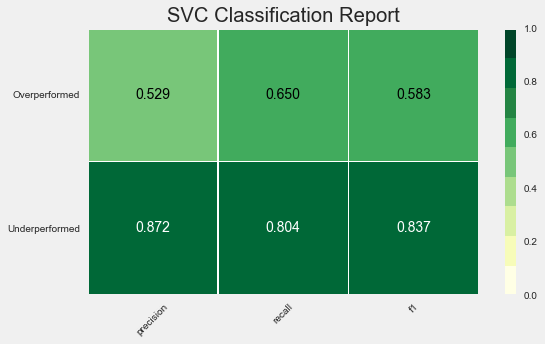

F1 SCORE NuSVC: 0.5831381733021078


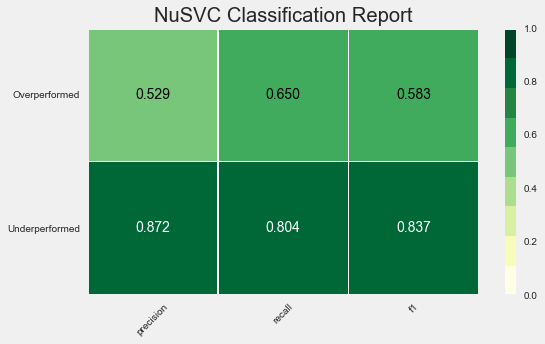

F1 SCORE SGDClassifier: 0.5831381733021078


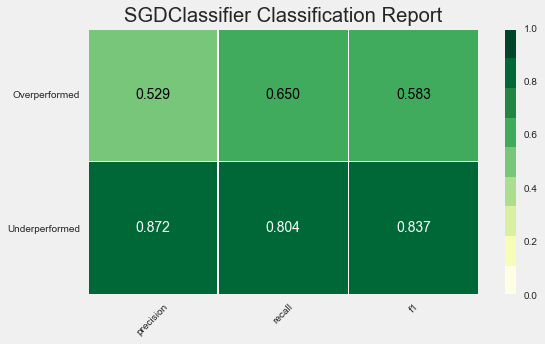

In [25]:
for model in final_models:
    score_model(X, y, model)
    visualize_model(X, y, model)

# perform grid search to find best parameters for SVC and SGD model

In [26]:
param_grid_SVC = {
    'C' : [1, 10, 100, 1000],
    'gamma' : [1, 0.1, 0.001, 0.0001, 'auto'],
    'kernel' : ['linear', 'rbf'],
    'class_weight' : ['balanced']
}

In [27]:
preprocessor = Pipeline(
    [
        ("columns", ColumnTransformer(
            [
                ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical),
                ('scalar', MinMaxScaler(), numeric),
                ('scalar2', MinMaxScaler(), numeric2),
            ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [28]:
y_train = y[:X.index[X['Week'] > 14].tolist()[0]]
y_test = y[X.index[X['Week'] > 14].tolist()[0]:]
X_train = X[:X.index[X['Week'] > 14].tolist()[0]].drop('Week', axis = 'columns')
X_test = X[X.index[X['Week'] > 14].tolist()[0]:].drop('Week', axis = 'columns')

In [29]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

In [30]:
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

In [31]:
grid = GridSearchCV(
    # model: SVC
    SVC(),
    # Using the parameters defined above
    param_grid_SVC,
    # Refit an estimator using the best found parameters on the whole dataset
    refit = True,
    # >1 : the computation time for each fold and parameter candidate is displayed;
    # >2 : the score is also displayed;
    verbose = 2,
    # Maximize CPU
    n_jobs = -1
)

In [ ]:
grid.fit(X_train,y_train)

In [ ]:
grid.best_params_

F1 SCORE SVC: 0.5820721769499418


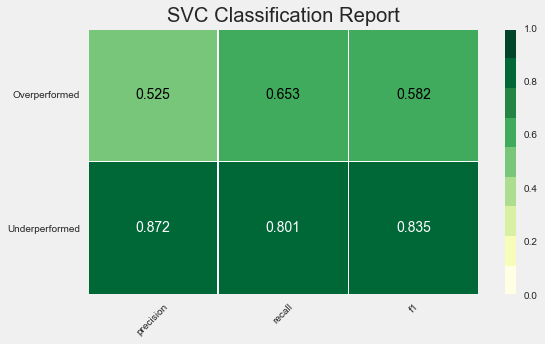

In [32]:
score_model(X, y, SVC(
    C = 1,
    class_weight = 'balanced',
    gamma = 'scale',
    kernel = 'rbf'
))    

visualize_model(X, y, SVC(
    C = 1,
    class_weight = 'balanced',
    gamma = 'scale',
    kernel = 'rbf'
))

In [33]:
param_grid_SDGClassifier = {
    'loss': ['hinge','log'],
    'max_iter' : [100, 500, 1000],
    'penalty': ['l1','l2'],
    'n_jobs': [-1],
    'class_weight' : ['balanced']
}

In [34]:
grid = GridSearchCV(
    # model: SVC
    SGDClassifier(),
    # Using the parameters defined above
    param_grid_SDGClassifier,
    # Refit an estimator using the best found parameters on the whole dataset
    refit = True,
    # >1 : the computation time for each fold and parameter candidate is displayed;
    # >2 : the score is also displayed;
    verbose = 2
)

In [35]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1; total time=   0.7s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1; total time=   0.6s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1; total time=   0.7s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1; total time=   0.7s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1; total time=   0.6s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2; total time=   0.4s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2; total time=   0.5s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2; total time=   0.4s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2; total time=   0.4s


C:\Users\griff\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2; total time=   0.5s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l1; total time=   0.8s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l1; total time=   0.5s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l1; total time=   0.6s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l1; total time=   0.8s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l1; total time=   0.7s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l2; total time=   0.2s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l2; total time=   0.5s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l2; total time=   0.4s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l2; total time=   0.4s


GridSearchCV(estimator=SGDClassifier(),
             param_grid={'class_weight': ['balanced'], 'loss': ['hinge', 'log'],
                         'max_iter': [100, 500, 1000], 'n_jobs': [-1],
                         'penalty': ['l1', 'l2']},
             verbose=2)

In [36]:
grid.best_params_

{'class_weight': 'balanced',
 'loss': 'hinge',
 'max_iter': 100,
 'n_jobs': -1,
 'penalty': 'l1'}

F1 SCORE SGDClassifier: 0.5831381733021078


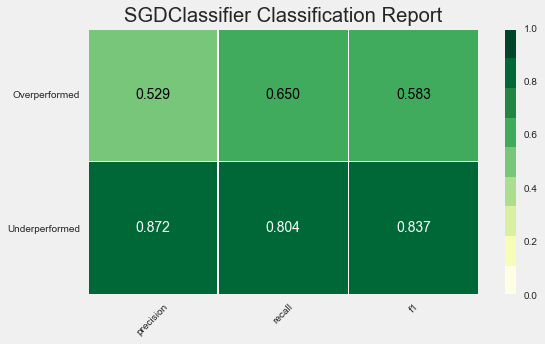

In [37]:
score_model(X, y, SGDClassifier(
    class_weight = 'balanced',
    loss = 'hinge',
    max_iter = 100,
    n_jobs = -1,
    penalty = 'l1'
)) 

visualize_model(X, y, SGDClassifier(
    class_weight = 'balanced',
    loss = 'hinge',
    max_iter = 100,
    n_jobs = -1,
    penalty = 'l1'
))

In [38]:
# Split dataframe into two dataframes: X will have all but target, y will have target
X = df.drop([
    'performance',
    'performance_class',
    'projected',
    'actual',
    'difference',
    'GameKey',
    'TeamID',
    'OpponentID',
    'ScoreID',
    'GameKey',
    'PlayerID',
    'TeamID',
    'OpponentID',
    'ScoreID',
    'week_id'
], axis = 'columns')

y = df['performance']

In [39]:
y_train = y[:X.index[X['Week'] > 14].tolist()[0]]
y_test = y[X.index[X['Week'] > 14].tolist()[0]:]
X_train = X[:X.index[X['Week'] > 14].tolist()[0]].drop('Week', axis = 'columns')
X_test = X[X.index[X['Week'] > 14].tolist()[0]:].drop('Week', axis = 'columns')

preprocessor = Pipeline(
    [
        ("columns", ColumnTransformer(
            [
                ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical),
                ('scalar', MinMaxScaler(), numeric),
                ('scalar2', MinMaxScaler(), numeric2),
            ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

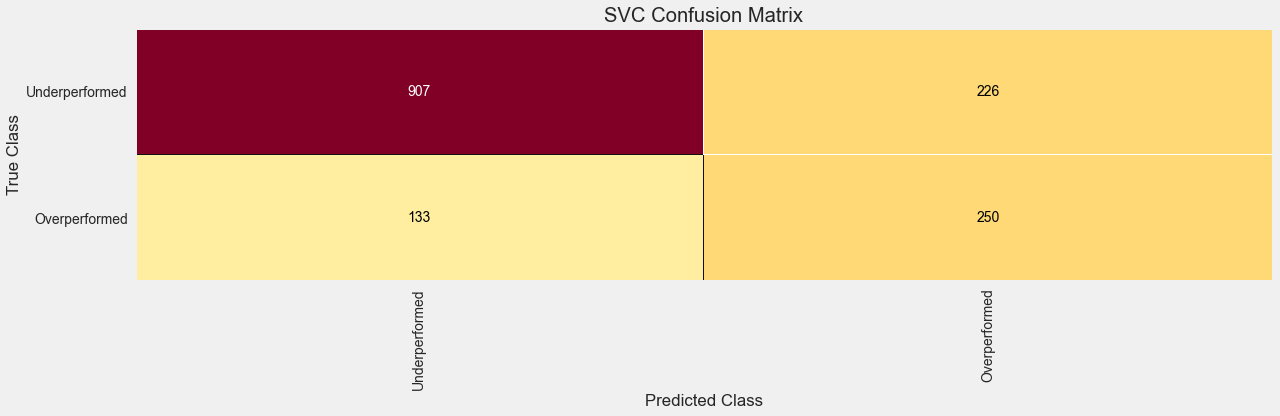

<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [40]:
from yellowbrick.classifier import ConfusionMatrix

model = SVC(
    C = 1,
    class_weight = 'balanced',
    gamma = 'scale',
    kernel = 'rbf'
)

cm = ConfusionMatrix(
    model,
    classes = ['Underperformed', 'Overperformed']
)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

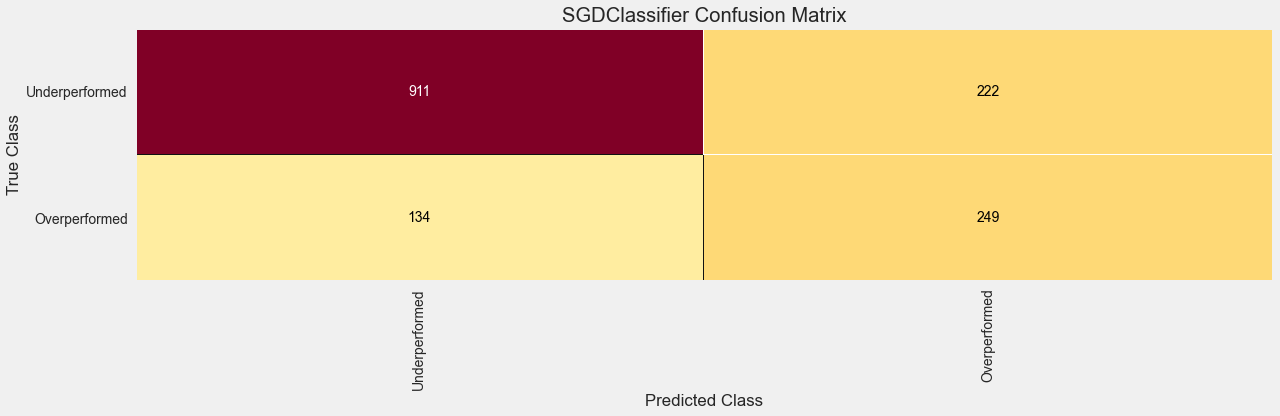

<AxesSubplot:title={'center':'SGDClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [41]:
model = SGDClassifier(
    class_weight = 'balanced',
    loss = 'hinge',
    max_iter = 100,
    n_jobs = -1,
    penalty = 'l1'
)

cm = ConfusionMatrix(
    model,
    classes = ['Underperformed', 'Overperformed'],
    #fontsize = 30
)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

# Times series split cross validation

perform a time series split cross validation to check the mean and standard deviation for each week's data

In [42]:

X_cv = preprocessor.fit_transform(X)
y_cv = LabelEncoder().fit_transform(y)

X_cv = pd.DataFrame(X_cv)
y_cv = pd.DataFrame(y_cv)

In [45]:
from sklearn.model_selection import KFold
from numpy import mean
from numpy import std


for n in range(1,18):
    
    print(f'Cross-validating fold {n}')
    # prepare the cross-validation procedure
    cv = KFold(
        n_splits = n+1,
        random_state = 123,
        shuffle = True
    )
    # create model
    model = SGDClassifier(
        class_weight = 'balanced',
        loss = 'hinge',
        max_iter = 500,
        n_jobs = -1,
        penalty = 'l1'
    )
    # evaluate model
    scores = cross_val_score(
        model,
        X_cv[:(X[X['Week'] <= n].index.to_list()[-1] + 1)],
        y_cv[:(X[X['Week'] <= n].index.to_list()[-1] + 1)],
        scoring = 'accuracy',
        cv = cv,
        n_jobs = -1
    )
    # report performance
    means = []
    means.append(mean(scores))
    print(
        f'Accuracy: Mean: {mean(scores)}, stdev: {std(scores)}'
        '\n'
    )
print(f'Mean of mean scores: {sum(means) / len(means)}')

Cross-validating fold 1
Accuracy: Mean: 0.6464646464646464, stdev: 0.01010101010101011

Cross-validating fold 2
Accuracy: Mean: 0.6628883291351805, stdev: 0.031800834365080785

Cross-validating fold 3
Accuracy: Mean: 0.6410563099141805, stdev: 0.10707419933030637

Cross-validating fold 4
Accuracy: Mean: 0.6930629669156885, stdev: 0.06405051374020769

Cross-validating fold 5
Accuracy: Mean: 0.7459986082115518, stdev: 0.015595640105090437

Cross-validating fold 6
Accuracy: Mean: 0.7455081001472754, stdev: 0.014964224796324631

Cross-validating fold 7
Accuracy: Mean: 0.7538288725818884, stdev: 0.01127664268966428

Cross-validating fold 8
Accuracy: Mean: 0.7575176589303734, stdev: 0.011703773988111333

Cross-validating fold 9
Accuracy: Mean: 0.7652894997073723, stdev: 0.00829385761105977

Cross-validating fold 10
Accuracy: Mean: 0.7678529381499739, stdev: 0.013032241753438895

Cross-validating fold 11
Accuracy: Mean: 0.7704731230180332, stdev: 0.012358485763605055

Cross-validating fold 12

# Pickle model for future use

In [46]:
import pickle

In [47]:
filename = '../../foo/offense_model.sav'
pickle.dump(model, open(filename, 'wb'))